In [29]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('this will not show')

import pandas as pd
pd.set_option("future.no_silent_downcasting", True)

In [ ]:
# synthetic data 
import pandas as pd
import numpy as np

np.random.seed(42) # for reproducibility
num_customers = 100
current_year = 2025

data_churn = pd.DataFrame({
    'customer_id': range(1, num_customers + 1),
    'monthly_data_usage_M0': np.random.normal(50, 15, num_customers).round(2), # current month
    'monthly_data_usage_M1': np.random.normal(52, 16, num_customers).round(2), # previous month
    'monthly_data_usage_M2': np.random.normal(55, 17, num_customers).round(2), # 2 months ago
    'num_support_calls_last_month': np.random.randint(0, 6, num_customers),
    'contract_start_year': np.random.randint(2018, current_year, num_customers),
    'contract_start_month': np.random.randint(1, 13, num_customers),
    'last_service_upgrade_days_ago': np.random.randint(10, 730, num_customers),
    'avg_call_duration_min': np.random.normal(15, 5, num_customers).round(2),
    'has_international_plan': np.random.choice([0, 1], num_customers, p=[0.7, 0.3]),
    'international_call_minutes': np.random.normal(10, 20, num_customers).round(2)
})

# Ensure data usage is non-negative
data_churn[['monthly_data_usage_M0', 'monthly_data_usage_M1', 'monthly_data_usage_M2']] = \
    data_churn[['monthly_data_usage_M0', 'monthly_data_usage_M1', 'monthly_data_usage_M2']].apply(lambda x: np.maximum(0, x))
data_churn['international_call_minutes'] = np.maximum(0, data_churn['international_call_minutes'])

# Calculate contract duration in months
data_churn['contract_duration_months'] = (
    (current_year - data_churn['contract_start_year']) * 12 +
    (6 - data_churn['contract_start_month']) # Assuming current month is June (6)
)
data_churn['contract_duration_months'] = np.maximum(1, data_churn['contract_duration_months']) # Ensure min 1 month


print("--- Customer Churn Data BEFORE Feature Engineering ---")
print(data_churn.head())
print("\n" + "="*50 + "\n")

# --- Applying Feature Engineering for Customer Churn ---

# 1. Aggregating Usage Patterns: Average monthly data usage over the last 3 months
data_churn['Avg_Monthly_Data_Usage_3M'] = data_churn[[
    'monthly_data_usage_M0',
    'monthly_data_usage_M1',
    'monthly_data_usage_M2'
]].mean(axis=1).round(2)

# 2. Support Call Frequency: Number of support calls per month of contract duration
data_churn['Support_Call_Frequency'] = (
    data_churn['num_support_calls_last_month'] / data_churn['contract_duration_months']
).round(4)

# 3. Time-Based Feature: Boolean for contract expiring soon (e.g., within next 6 months)
# Assuming a typical contract is 24 months for simplicity, and customers might renew earlier
data_churn['Months_Remaining_on_Contract'] = np.random.randint(1, 25, num_customers) # Synthetic remaining months
data_churn['Is_Contract_Expiring_Soon'] = (data_churn['Months_Remaining_on_Contract'] <= 6).astype(int)

# 4. Interaction Feature: Data usage per average call duration
# Add a small epsilon to avoid division by zero for avg_call_duration_min
data_churn['Data_Usage_per_Call_Duration'] = (
    data_churn['monthly_data_usage_M0'] / (data_churn['avg_call_duration_min'] + 0.01)
).round(2)

# 5. Ratio of international calls to total call duration (synthetic total call duration)
data_churn['total_call_minutes'] = data_churn['avg_call_duration_min'] * 30 # rough estimate
data_churn['International_Call_Ratio'] = (
    data_churn['international_call_minutes'] / (data_churn['total_call_minutes'] + 0.01)
).round(4)
# Cap the ratio at 1 if somehow it exceeds due to synthetic data
data_churn['International_Call_Ratio'] = np.minimum(1, data_churn['International_Call_Ratio'])


print("--- Customer Churn Data AFTER Feature Engineering ---")
# Display only the original and new engineered features for clarity
engineered_features_churn = [
    'customer_id',
    'monthly_data_usage_M0', 'monthly_data_usage_M1', 'monthly_data_usage_M2', # original
    'num_support_calls_last_month', 'contract_duration_months', # original
    'Avg_Monthly_Data_Usage_3M', 'Support_Call_Frequency',
    'Months_Remaining_on_Contract', 'Is_Contract_Expiring_Soon',
    'Data_Usage_per_Call_Duration', 'International_Call_Ratio'
]
print(data_churn[engineered_features_churn].head())


--- Customer Churn Data BEFORE Feature Engineering ---
   customer_id  monthly_data_usage_M0  monthly_data_usage_M1  \
0            1                  57.45                  29.35   
1            2                  47.93                  45.27   
2            3                  59.72                  46.52   
3            4                  72.85                  39.16   
4            5                  46.49                  49.42   

   monthly_data_usage_M2  num_support_calls_last_month  contract_start_year  \
0                  61.08                             0                 2023   
1                  64.53                             3                 2024   
2                  73.41                             1                 2020   
3                  72.91                             4                 2019   
4                  31.58                             0                 2019   

   contract_start_month  last_service_upgrade_days_ago  avg_call_duration_min  \
0   

In [31]:
import os
import pandas as pd

# download the dataset
current_dir =  os.getcwd()
parent_dir = os.path.dirname(current_dir)
file_name = 'online_retail.csv'
csv_file_path = f'{parent_dir}/data/raw/{file_name}'

df = pd.read_csv(csv_file_path)

# update column titles
for col in df.columns:
    col_revised = col.replace(' ', '_').lower().replace('__', '_')
    df[col_revised] = df[col]
    df = df.drop(columns=col, axis='columns')

df.head().transpose()

,0,1,2,3,4
invoiceno,536365,536365,536365,536365,536365
stockcode,85123A,71053,84406B,84029G,84029E
description,WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL LANTERN,CREAM CUPID HEARTS COAT HANGER,KNITTED UNION FLAG HOT WATER BOTTLE,RED WOOLLY HOTTIE WHITE HEART.
quantity,6,6,8,6,6
invoicedate,12/1/2010 8:26,12/1/2010 8:26,12/1/2010 8:26,12/1/2010 8:26,12/1/2010 8:26
unitprice,2.55,3.39,2.75,3.39,3.39
customerid,17850.0,17850.0,17850.0,17850.0,17850.0
country,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   invoiceno    541909 non-null  object 
 1   stockcode    541909 non-null  object 
 2   description  540455 non-null  object 
 3   quantity     541909 non-null  int64  
 4   invoicedate  541909 non-null  object 
 5   unitprice    541909 non-null  float64
 6   customerid   406829 non-null  float64
 7   country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [33]:
# looking at data types. convert some of them for model interpretation
import numpy as np

obj_cols = ['invoiceno', 'stockcode', 'country', 'invoicedate', 'description']
null_vals = ['', 'nan', 'N/A', None, 'na', 'None', 'none']
replaced_null = { item: np.nan for item in null_vals }

for col in obj_cols:
    df[col].replace(replaced_null, inplace=True)
    print(f'{col} NaN?: {df[col].isna().sum()}')

df.info()

invoiceno NaN?: 0
stockcode NaN?: 0
country NaN?: 0
invoicedate NaN?: 0
description NaN?: 1454
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   invoiceno    541909 non-null  object 
 1   stockcode    541909 non-null  object 
 2   description  540455 non-null  object 
 3   quantity     541909 non-null  int64  
 4   invoicedate  541909 non-null  object 
 5   unitprice    541909 non-null  float64
 6   customerid   406829 non-null  float64
 7   country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [34]:
# from collections import Counter

for i, col in enumerate(df.columns):
    unique_num = df[col].nunique()
    nan_num = df[col].isna().sum()
    print(f'{i}. {col} - {unique_num:,} data points (missing data: {nan_num:,})')
   

0. invoiceno - 25,900 data points (missing data: 0)
1. stockcode - 4,070 data points (missing data: 0)
2. description - 4,223 data points (missing data: 1,454)
3. quantity - 722 data points (missing data: 0)
4. invoicedate - 23,260 data points (missing data: 0)
5. unitprice - 1,630 data points (missing data: 0)
6. customerid - 4,372 data points (missing data: 135,080)
7. country - 38 data points (missing data: 0)


In [35]:
df_rev = df.copy()
df_rev = df_rev.drop(columns='description')
df_rev['is_registered'] = np.where(df_rev['customerid'].isna(), 0, 1)


for i, item in enumerate(df_rev.dtypes):
    print(item, ' -- ', df_rev.columns[i])

print(df_rev.dtypes)

object  --  invoiceno
object  --  stockcode
int64  --  quantity
object  --  invoicedate
float64  --  unitprice
float64  --  customerid
object  --  country
int64  --  is_registered
invoiceno         object
stockcode         object
quantity           int64
invoicedate       object
unitprice        float64
customerid       float64
country           object
is_registered      int64
dtype: object


In [36]:
import pandas as pd

df['invoicedate'] = pd.to_datetime(df['invoicedate'])
df['customerid'] = df['customerid'].astype('Int64')

In [37]:
cat_cols = ['invoiceno', 'stockcode', 'quantity', 'customerid','country', 'is_registered']
num_cols = ['unitprice']
dt_cols = ['invoicedata']

In [38]:
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   invoiceno      541909 non-null  object 
 1   stockcode      541909 non-null  object 
 2   quantity       541909 non-null  int64  
 3   invoicedate    541909 non-null  object 
 4   unitprice      541909 non-null  float64
 5   customerid     406829 non-null  float64
 6   country        541909 non-null  object 
 7   is_registered  541909 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 33.1+ MB


In [39]:
# data distribution types
import pandas as pd

# handle date time values
df_rev['invoicedate'] = pd.to_datetime(df_rev['invoicedate'])
df_rev['year'] = df_rev['invoicedate'].dt.year
df_rev['year_month'] = df_rev['invoicedate'].dt.to_period('M')
df_rev['month_name'] = df_rev['invoicedate'].dt.strftime('%b')
df_rev['day_of_week'] = df_rev['invoicedate'].dt.strftime('%a')
# df_rev = df_rev.sort_values('invoicedate').drop(columns='invoicedate')

# add sales column
df_rev['sales'] = df_rev['quantity'] * df_rev['unitprice']

df_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   invoiceno      541909 non-null  object        
 1   stockcode      541909 non-null  object        
 2   quantity       541909 non-null  int64         
 3   invoicedate    541909 non-null  datetime64[ns]
 4   unitprice      541909 non-null  float64       
 5   customerid     406829 non-null  float64       
 6   country        541909 non-null  object        
 7   is_registered  541909 non-null  int64         
 8   year           541909 non-null  int32         
 9   year_month     541909 non-null  period[M]     
 10  month_name     541909 non-null  object        
 11  day_of_week    541909 non-null  object        
 12  sales          541909 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int32(1), int64(2), object(5), period[M](1)
memory usage: 51.7+ MB


In [40]:
df_rev.head().transpose()

,0,1,2,3,4
invoiceno,536365,536365,536365,536365,536365
stockcode,85123A,71053,84406B,84029G,84029E
quantity,6,6,8,6,6
invoicedate,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01 08:26:00
unitprice,2.55,3.39,2.75,3.39,3.39
customerid,17850.0,17850.0,17850.0,17850.0,17850.0
country,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom
is_registered,1,1,1,1,1
year,2010,2010,2010,2010,2010
year_month,2010-12,2010-12,2010-12,2010-12,2010-12


In [41]:
cat_cols = ['invoiceno', 'stockcode', 'quantity', 'customerid', 'country', 'is_registered', 'year', 'year_month', 'month_name', 'day_of_week']
num_cols = ['unitprice', 'sales']


unitprice: Max: 38,970.0, Min: -11,062.1, Mean: 4.6, Std: 96.8

sales: Max: 168,469.6, Min: -168,469.6, Mean: 18.0, Std: 378.8


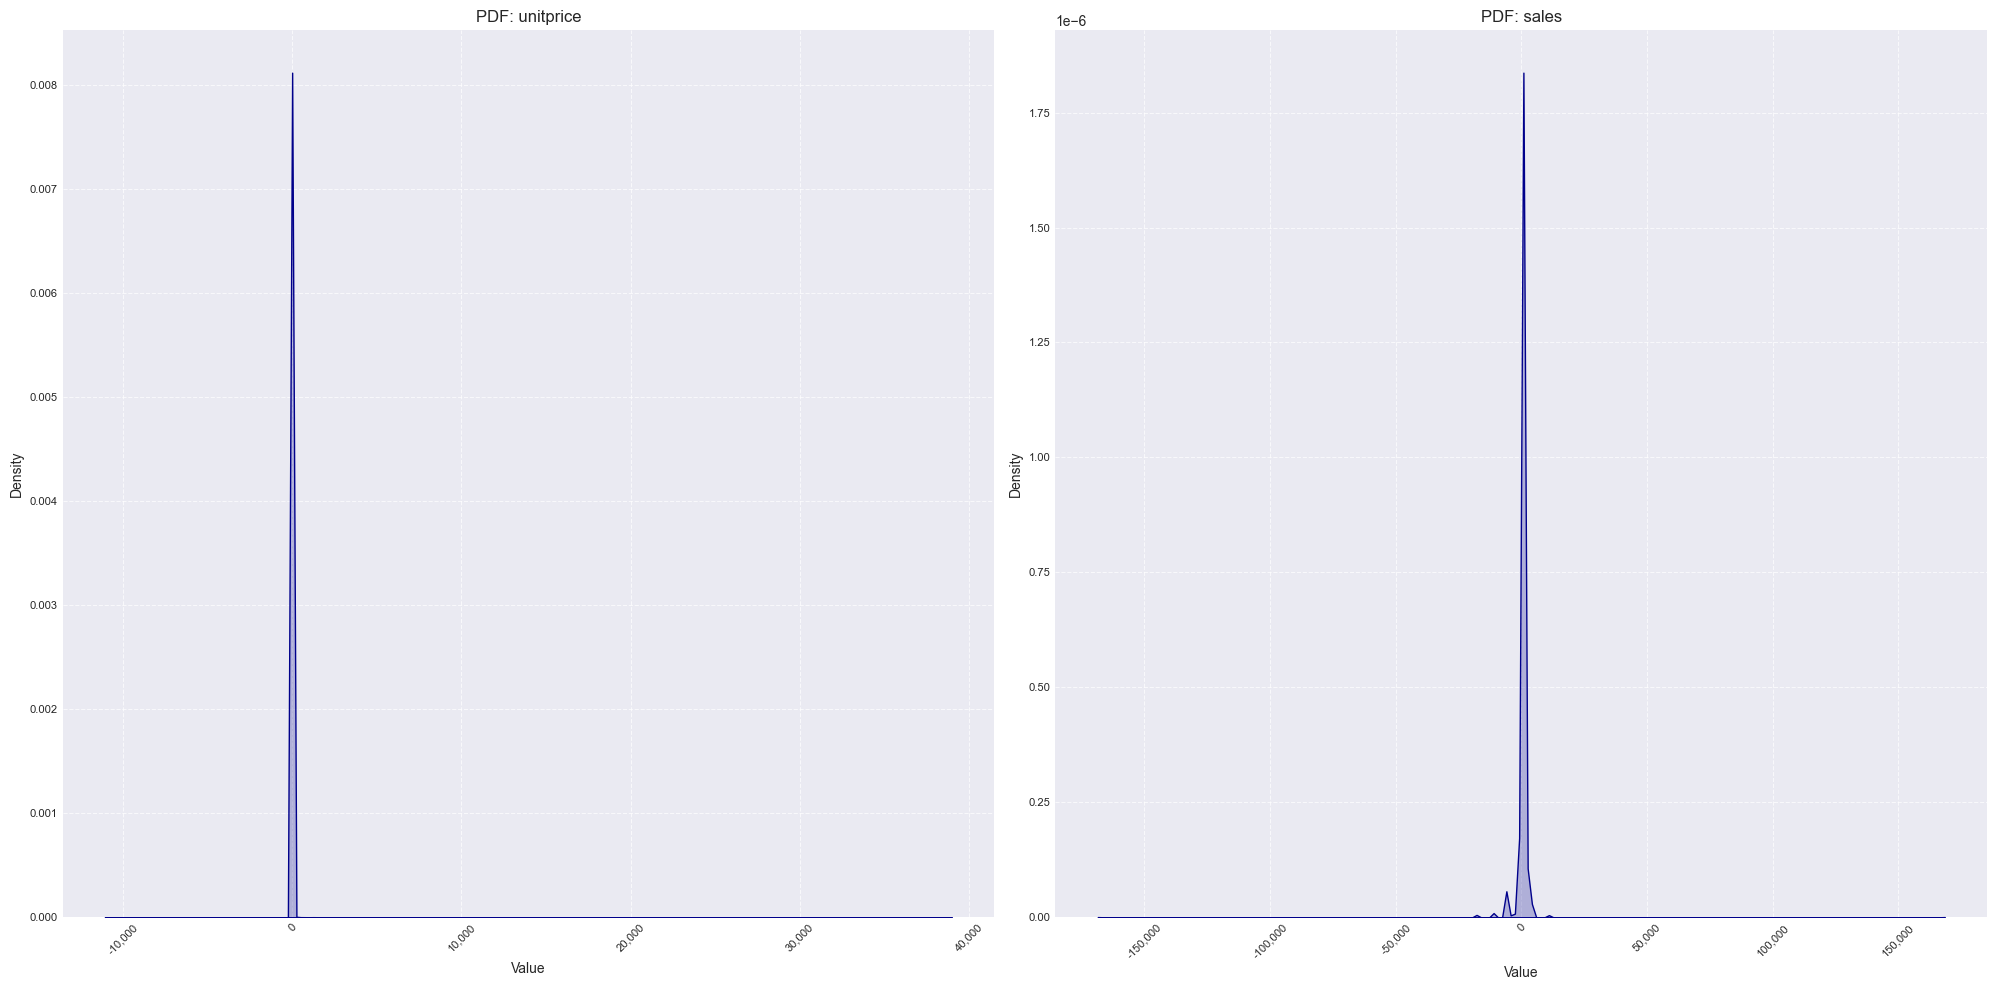

In [42]:
# pdf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

plt.style.use('seaborn-v0_8-darkgrid')
formatter = mtick.FuncFormatter(lambda x, p: format(int(x), ','))
cmap = 'flare'
df_plt = df_rev.copy()

plt.figure(figsize=(30, 10))

for i, col in enumerate(num_cols):
    plt.subplot(1, 3, i+1) 
    sns.kdeplot(df_plt[col], fill=True, color='darkblue', linewidth=1) # type: ignore
    plt.title(f'PDF: {col}', fontsize=12)
    plt.xlabel('Value', fontsize=10)
    plt.ylabel('Density', fontsize=10)

    if col in ['sales', 'unitprice']: plt.gca().xaxis.set_major_formatter(formatter)
    plt.tick_params(axis='x', labelsize=8, rotation=45 if col in ['sales', 'unitprice'] else 0)
    plt.tick_params(axis='y', labelsize=8)
    plt.grid(True, linestyle='--', alpha=0.7)

    print(f'\n{col}: Max: {df_plt[col].max():,.1f}, Min: {df_plt[col].min():,.1f}, Mean: {df_plt[col].mean():,.1f}, Std: {df_plt[col].std():,.1f}')
   
plt.tight_layout()
plt.show()


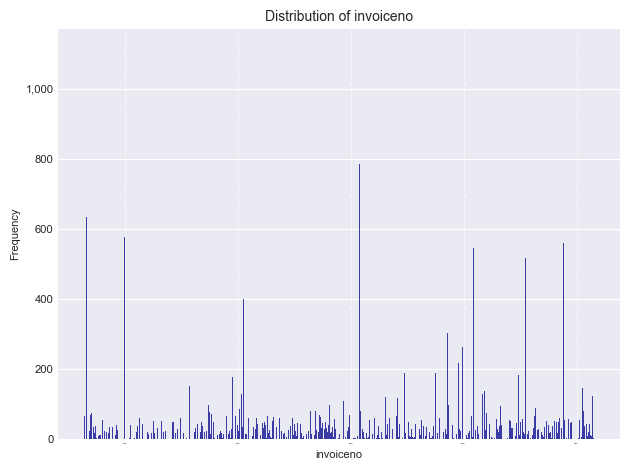

Medium 560688.0


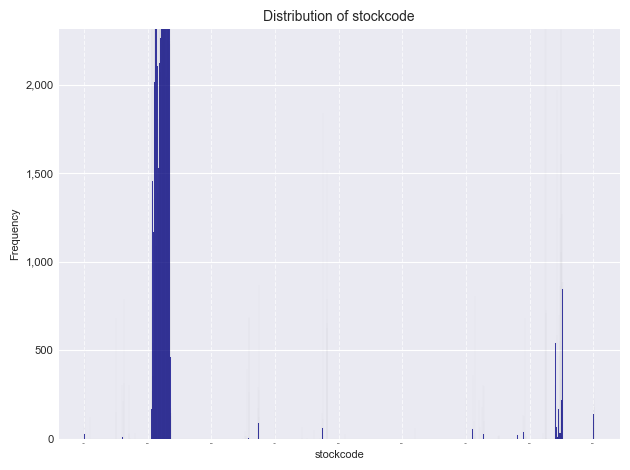

Medium 22560.0


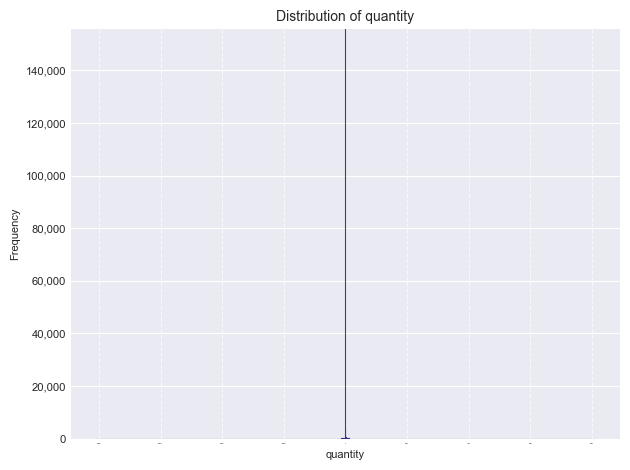

Medium 3.0


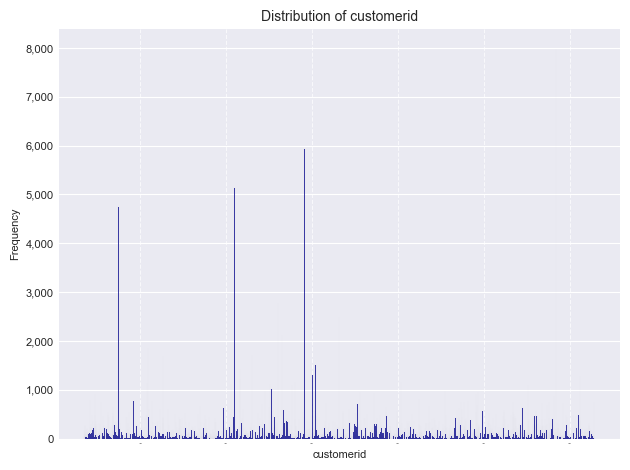

Medium 15152.0


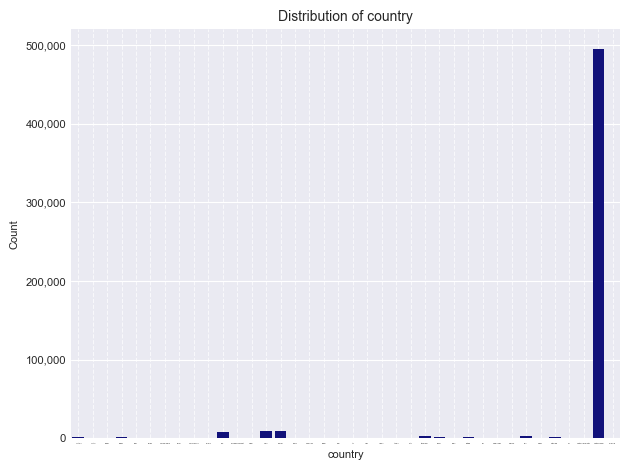

Medium 373.5


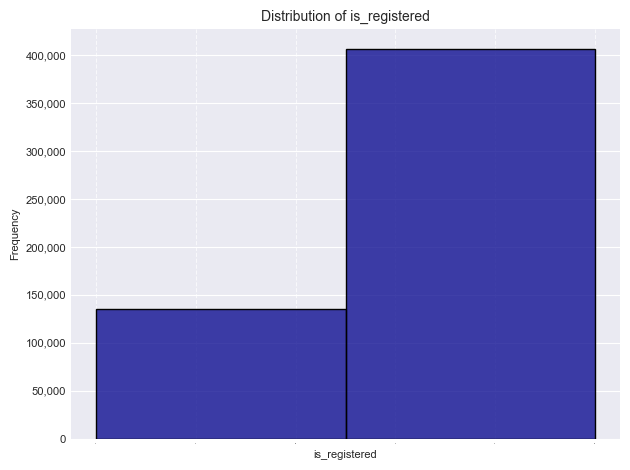

Medium 1.0


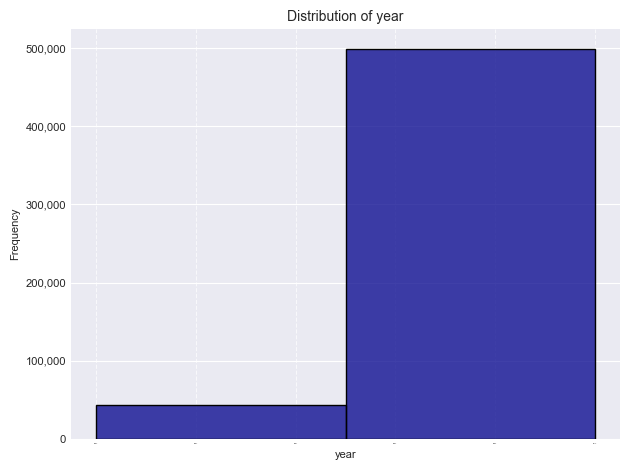

Medium 2011.0


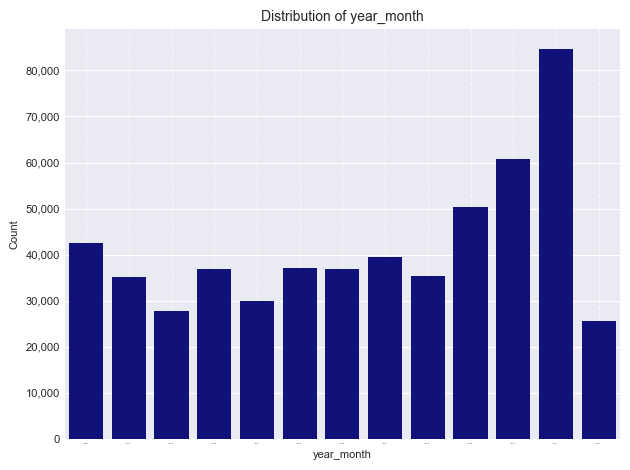

Medium 2011-07


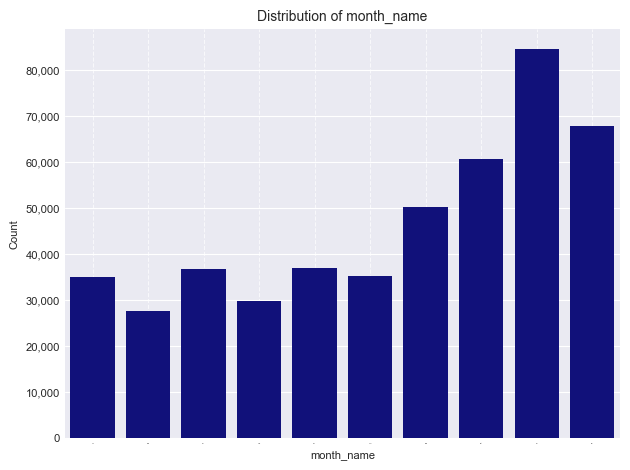

Medium 36952.0


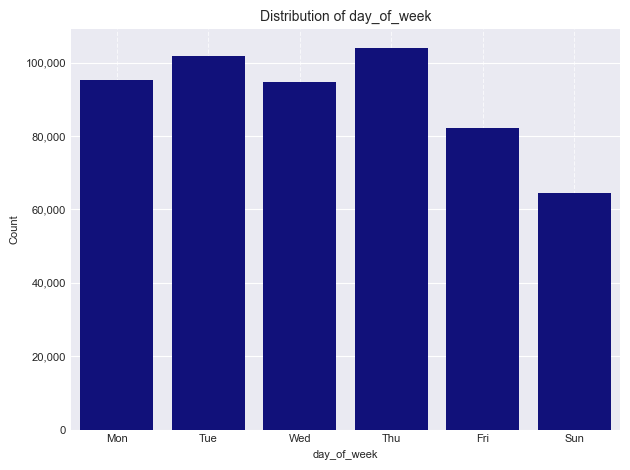

Medium 94838.0


In [43]:
# histogram for cat features 
import matplotlib.pyplot as plt
import seaborn as sns

for col in ['stockcode', 'country', 'quantity']:
    df_rev.loc[np.random.choice(df_rev.index, 5, replace=False), col] = np.nan

df_plot = df_rev.copy()
df_plot['customerid'] = df_plot['customerid'].astype(str)

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

figsize =(8, 4)
plt.plot(figsize=figsize)

for i, col in enumerate(cat_cols):  
    order = None
    if col not in ['country', 'year_month', 'day_of_week', 'month_name']:
        df_plot[col] = pd.to_numeric(df_plot[col], errors='coerce')

    if pd.api.types.is_numeric_dtype(df_plot[col].dtype) and not df_plot[col].isnull().all():
        sns.histplot(df_plot[col].dropna(), kde=False, bins=len(df_plot[col].unique()), color='darkblue') # type: ignore
        plt.ylabel('Frequency')
    else:
        if col == 'month_name':
            order = [m for m in month_order if m in df_plot[col].unique()] 
        elif col == 'day_of_week':
            order = [d for d in day_order if d in df_plot[col].unique()]
        else:
            unique_values = df_plot[col].dropna().unique()
            unique_values_str = [str(val) for val in unique_values]
            try:
                order = sorted(unique_values_str, key=lambda x: float(x))
            except ValueError:
                order = sorted(unique_values_str)

        sns.countplot(x=df_plot[col], order=order, color='darkblue', lw=0)
  
    max_counts = df_plot[col].value_counts().max()
    if np.isfinite(max_counts) and max_counts > 0: plt.gca().set_ylim(0, max_counts * 1.05)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().tick_params(axis='y', labelsize=8)
    plt.gca().tick_params(axis='x', labelsize=8 if order and len(order) < 10 else 0)

    plt.title(f'Distribution of {col}', fontsize=10)
    plt.xlabel(col, fontsize=8)
    plt.ylabel('Frequency' if pd.api.types.is_numeric_dtype(df_plot[col]) else 'Count', fontsize=8)

    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    try:
        print(f'Medium {df_plot[col].median()}')
    except:
        print(f'Medium {df_plot[col].value_counts().median()}')



    year month_name        sales
0   2010        Dec   748957.020
5   2011        Jan   560000.260
4   2011        Feb   498062.650
8   2011        Mar   683267.080
1   2011        Apr   493207.121
9   2011        May   723333.510
7   2011        Jun   691123.120
6   2011        Jul   681300.111
2   2011        Aug   682680.510
12  2011        Sep  1019687.622
11  2011        Oct  1070704.670
10  2011        Nov  1461756.250
3   2011        Dec   433668.010


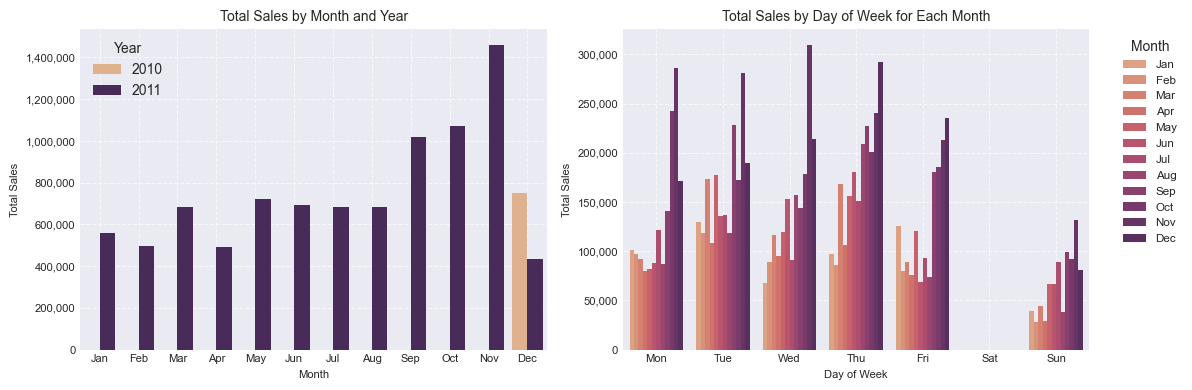

In [44]:
# project specific eda
# hypo 1
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.style.use('seaborn-v0_8-darkgrid')
formatter = mtick.FuncFormatter(lambda x, p: format(int(x), ','))
cmap = 'flare'
df_plt = df_rev.copy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
monthly_yearly_sales = df_plt.groupby(['year', 'month_name'])['sales'].sum().reset_index()
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_yearly_sales['month_name'] = pd.Categorical(monthly_yearly_sales['month_name'], categories=month_order, ordered=True)
monthly_yearly_sales = monthly_yearly_sales.sort_values(['year', 'month_name'])
print(monthly_yearly_sales)
sns.barplot(x='month_name', y='sales', hue='year', data=monthly_yearly_sales, 
            # marker='o', 
            palette=cmap)
plt.title('Total Sales by Month and Year', fontsize=10)
plt.xlabel('Month', fontsize=8)
plt.ylabel('Total Sales', fontsize=8)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().tick_params(axis='y', labelsize=8)
plt.gca().tick_params(axis='x', labelsize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Year')


plt.subplot(1, 2, 2)
sales_by_day_month = df_plt.groupby(['month_name', 'day_of_week'])['sales'].sum().reset_index()
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sales_by_day_month['day_of_week'] = pd.Categorical(sales_by_day_month['day_of_week'], categories=day_order, ordered=True)
sales_by_day_month['month_name'] = pd.Categorical(sales_by_day_month['month_name'], categories=month_order, ordered=True)
sales_by_day_month = sales_by_day_month.sort_values(['month_name', 'day_of_week'])
sns.barplot(x='day_of_week', y='sales', hue='month_name', data=sales_by_day_month, palette=cmap)
plt.title('Total Sales by Day of Week for Each Month', fontsize=10)
plt.xlabel('Day of Week', fontsize=8)
plt.ylabel('Total Sales', fontsize=8)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().tick_params(axis='y', labelsize=8)
plt.gca().tick_params(axis='x', labelsize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()

Plotting Monthly Product Quantity vs. Unit Price Bin by Month...


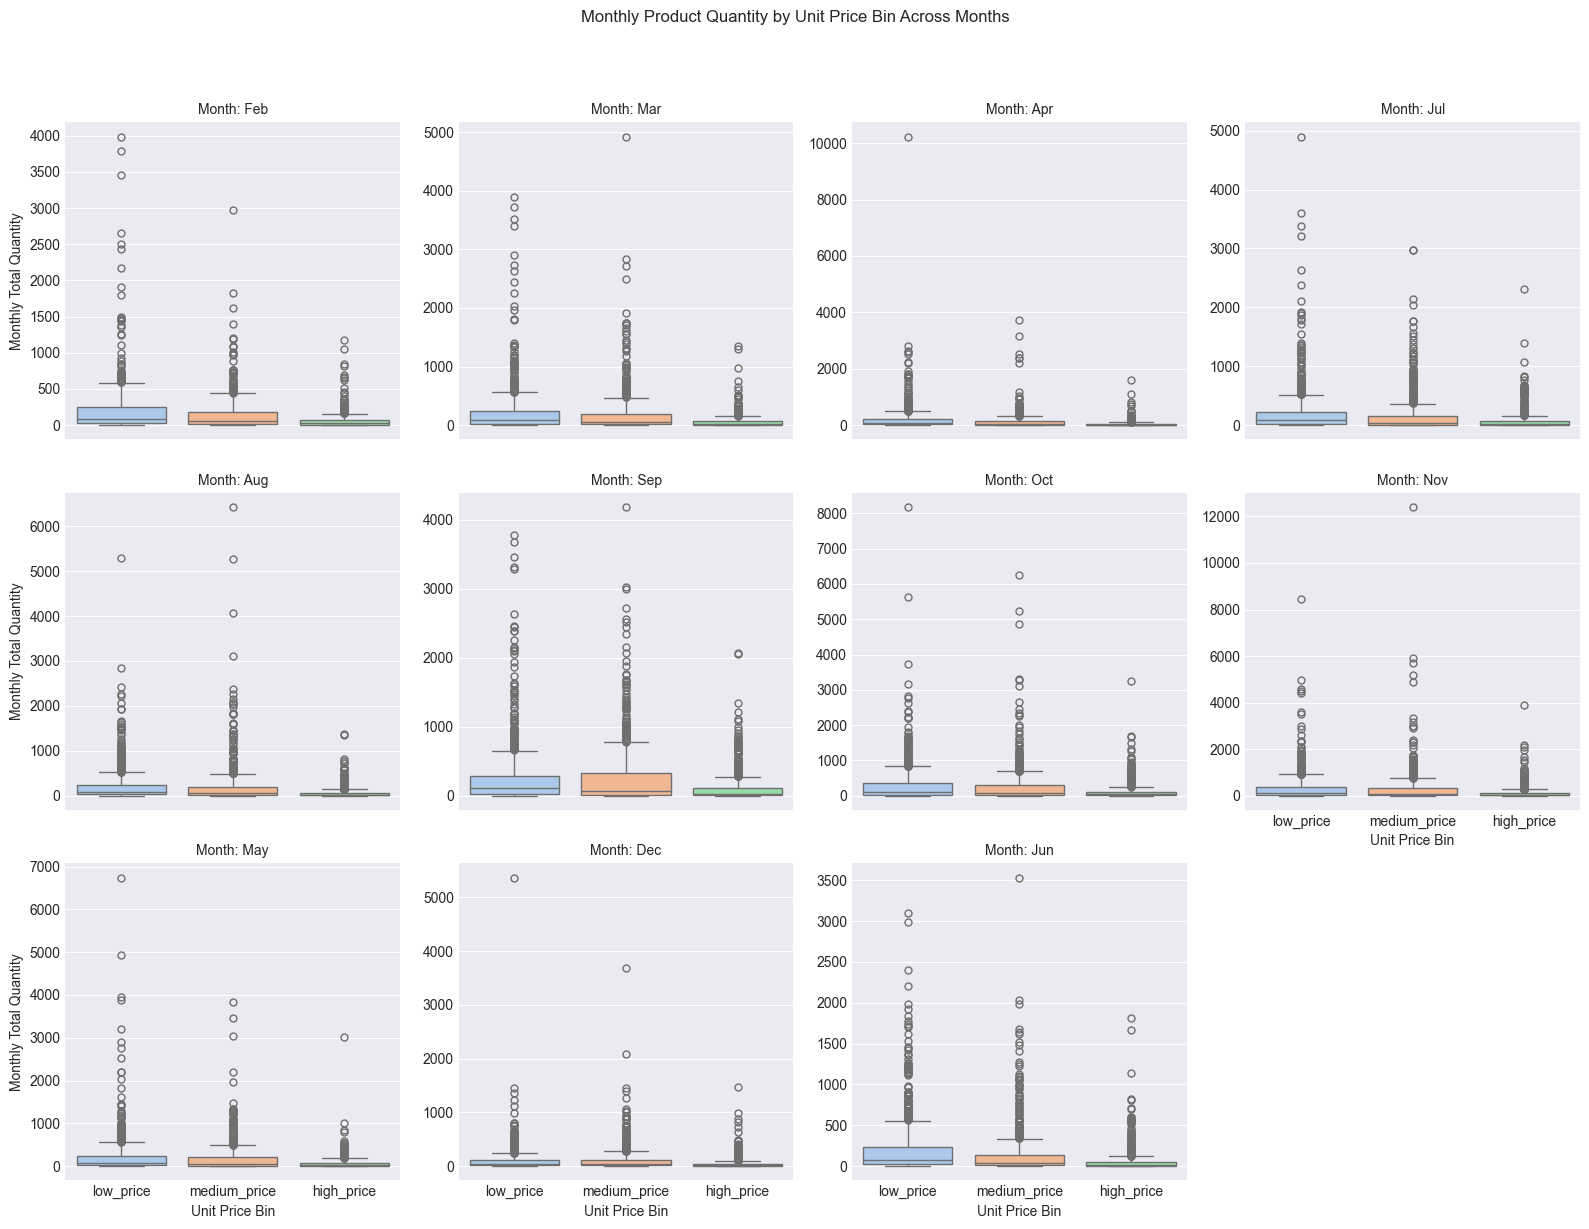

Plotting Monthly Product Quantity vs. Product Average Quantity Last Month...


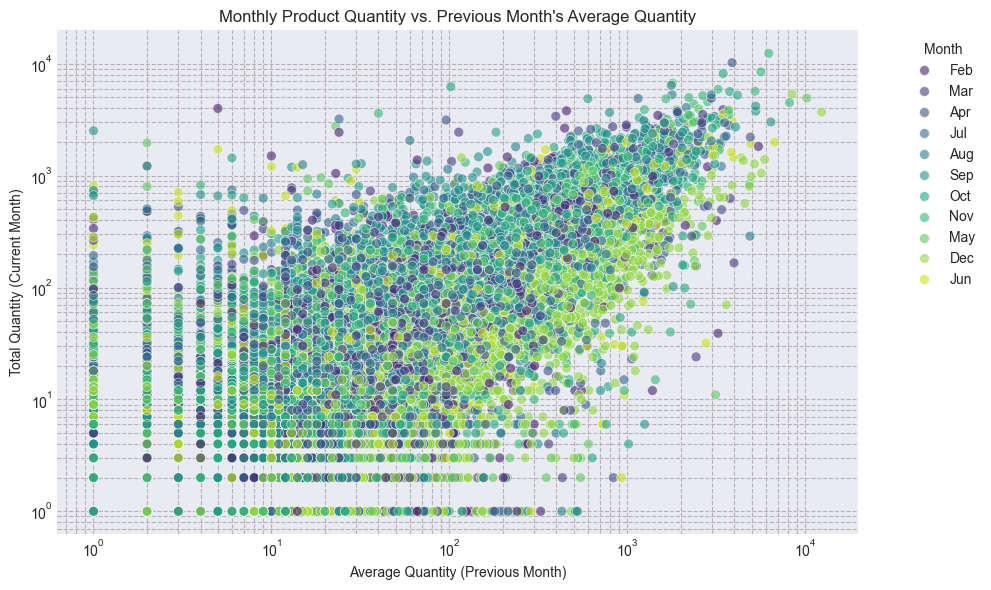

Plotting Monthly Product Quantity vs. Product Sales Growth Rate Last Month...


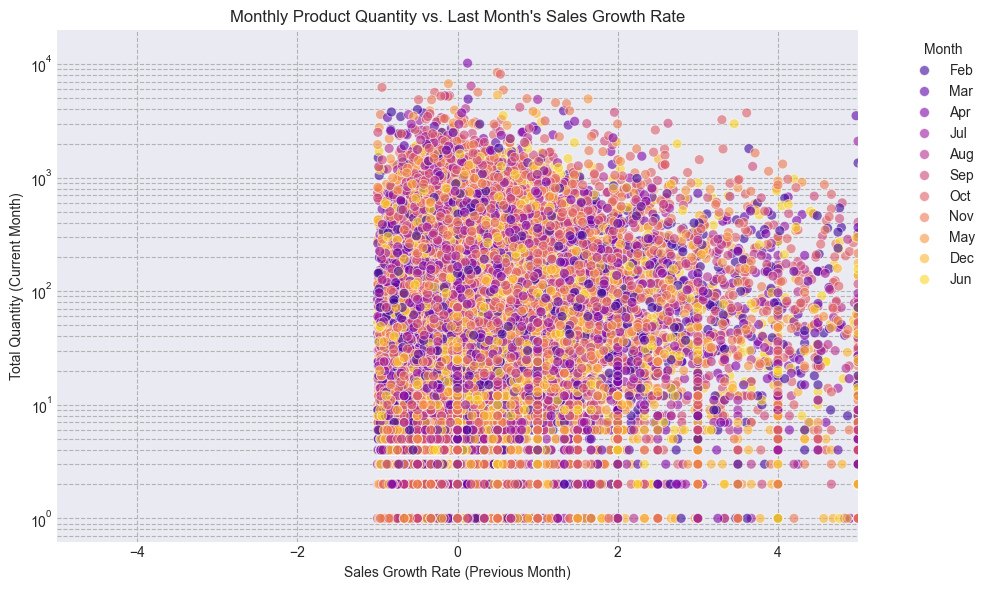

In [45]:
# hypo 2.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


df_cleaned = df_rev.copy()[
    (~df_rev['invoiceno'].astype(str).str.startswith('c')) &
    (df_rev['quantity'] > 0) &
    (df_rev['unitprice'] > 0)
].copy()

df_cleaned.dropna(subset=['customerid'], inplace=True)
df_cleaned['customerid'] = df_cleaned['customerid'].astype(int)

df_cleaned['invoice_period'] = df_cleaned['invoicedate'].dt.to_period('M')

df_product_monthly = df_cleaned.groupby(['stockcode', 'invoice_period']).agg(
    total_quantity=('quantity', 'sum'),
    avg_unit_price=('unitprice', 'mean')
).reset_index()

df_product_monthly['invoice_date_monthly'] = df_product_monthly['invoice_period'].dt.to_timestamp()
df_product_monthly['invoice_month_name'] = df_product_monthly['invoice_date_monthly'].dt.strftime('%b')

try:
    df_product_monthly['unit_price_bin'] = pd.qcut(
        df_product_monthly['avg_unit_price'],
        q=3,
        labels=['low_price', 'medium_price', 'high_price'],
        duplicates='drop'
    )
except ValueError as e:
    print(f"Could not create 3 bins for 'avg_unit_price' due to: {e}. Using fewer bins or alternative method.")
    if df_product_monthly['avg_unit_price'].nunique() > 1:
        df_product_monthly['unit_price_bin'] = pd.cut(
            df_product_monthly['avg_unit_price'],
            bins=3,
            labels=['low_price', 'medium_price', 'high_price'],
            include_lowest=True
        )
    else:
        df_product_monthly['unit_price_bin'] = 'single_price'


df_product_monthly = df_product_monthly.sort_values(by=['stockcode', 'invoice_period'])
df_product_monthly['product_avg_quantity_last_month'] = df_product_monthly.groupby('stockcode')['total_quantity'].shift(1)

df_product_monthly['product_avg_quantity_two_months_ago'] = df_product_monthly.groupby('stockcode')['total_quantity'].shift(2)
df_product_monthly['product_sales_growth_last_month'] = (
    df_product_monthly['product_avg_quantity_last_month'] - df_product_monthly['product_avg_quantity_two_months_ago']
) / df_product_monthly['product_avg_quantity_two_months_ago']
df_product_monthly['product_sales_growth_last_month'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_product_monthly.dropna(subset=['product_avg_quantity_last_month', 'product_sales_growth_last_month', 'unit_price_bin'], inplace=True)


print("Plotting Monthly Product Quantity vs. Unit Price Bin by Month...")
g = sns.catplot(
    data=df_product_monthly,
    x='unit_price_bin',
    y='total_quantity',
    col='invoice_month_name',
    kind='box',
    col_wrap=4,
    height=4,
    aspect=1,
    palette='pastel',
    sharey=False,
    order=['low_price', 'medium_price', 'high_price']
)
g.set_axis_labels("Unit Price Bin", "Monthly Total Quantity")
g.set_titles("Month: {col_name}")
plt.suptitle('Monthly Product Quantity by Unit Price Bin Across Months', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # type: ignore
plt.show()

print("Plotting Monthly Product Quantity vs. Product Average Quantity Last Month...")
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_product_monthly,
    x='product_avg_quantity_last_month',
    y='total_quantity',
    alpha=0.6,
    s=50,
    hue='invoice_month_name',
    palette='viridis'
)
plt.title('Monthly Product Quantity vs. Previous Month\'s Average Quantity')
plt.xlabel('Average Quantity (Previous Month)')
plt.ylabel('Total Quantity (Current Month)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--", c="0.7")
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("Plotting Monthly Product Quantity vs. Product Sales Growth Rate Last Month...")
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_product_monthly,
    x='product_sales_growth_last_month',
    y='total_quantity',
    alpha=0.6,
    s=50,
    hue='invoice_month_name',
    palette='plasma'
)
plt.title('Monthly Product Quantity vs. Last Month\'s Sales Growth Rate')
plt.xlabel('Sales Growth Rate (Previous Month)')
plt.ylabel('Total Quantity (Current Month)')
plt.xlim(-5, 5)
plt.yscale('log')
plt.grid(True, which="both", ls="--", c="0.7")
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

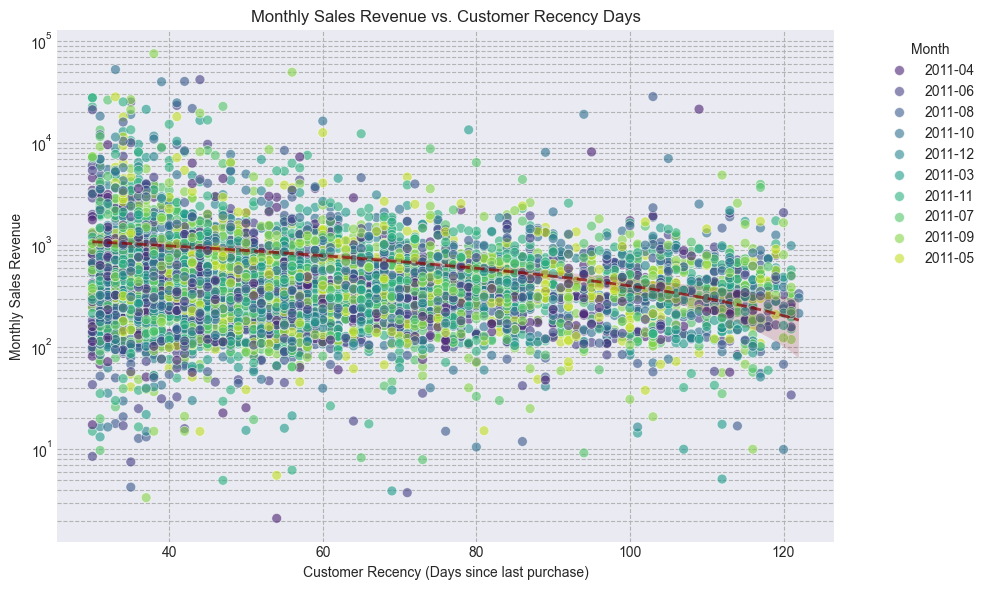

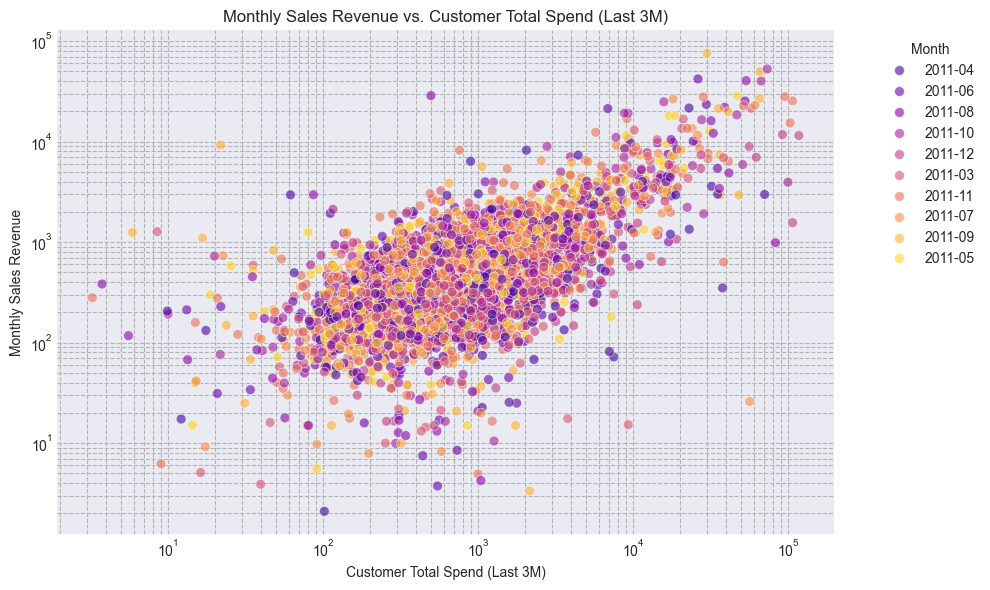

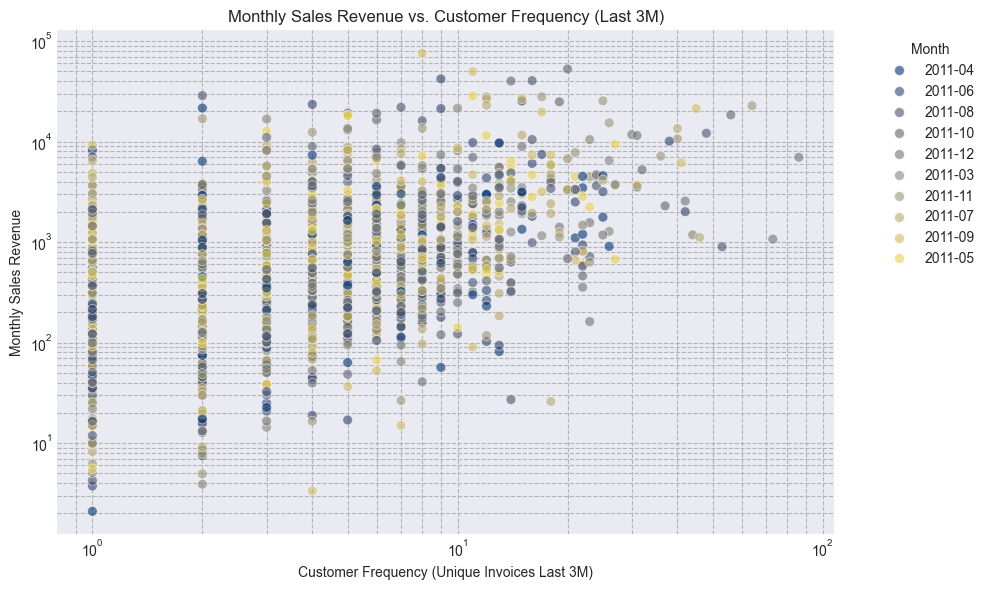

In [46]:
# hypo 3.
import seaborn as sns
import matplotlib.pyplot as plt

df_cleaned = df_rev.copy()[
    (~df_rev['invoiceno'].astype(str).str.startswith('c')) &
    (df_rev['quantity'] > 0) &
    (df_rev['unitprice'] > 0)
].copy()

df_cleaned['invoicedate'] = pd.to_datetime(df_cleaned['invoicedate'], errors='coerce')
df_cleaned.dropna(subset=['invoicedate', 'customerid'], inplace=True)
df_cleaned['customerid'] = df_cleaned['customerid'].astype(int)
df_cleaned['total_price'] = df_cleaned['quantity'] * df_cleaned['unitprice']
df_cleaned['invoice_period'] = df_cleaned['invoicedate'].dt.to_period('M')

customer_monthly_data = df_cleaned.groupby(['customerid', 'invoice_period']).agg(
    monthly_sales_revenue=('total_price', 'sum'),
    monthly_unique_invoices=('invoiceno', 'nunique'),
    last_purchase_date=('invoicedate', 'max')
).reset_index()

customer_monthly_data = customer_monthly_data.sort_values(by=['customerid', 'invoice_period'])
customer_monthly_data['invoice_timestamp_end'] = customer_monthly_data['invoice_period'].dt.end_time
customer_monthly_data['prev_last_purchase_date'] = customer_monthly_data.groupby('customerid')['last_purchase_date'].shift(1)
customer_monthly_data['customer_recency_days'] = (
    customer_monthly_data['invoice_timestamp_end'] - customer_monthly_data['prev_last_purchase_date']
).dt.days
all_customer_months = pd.MultiIndex.from_product(
    [df_cleaned['customerid'].unique(), df_cleaned['invoice_period'].unique()], # type: ignore
    names=['customerid', 'invoice_period']
).to_frame(index=False)
customer_monthly_full = all_customer_months.merge(
    df_cleaned.groupby(['customerid', 'invoice_period']).agg(
        monthly_total_price=('total_price', 'sum'),
        monthly_invoice_count=('invoiceno', 'nunique')
    ).reset_index(),
    on=['customerid', 'invoice_period'],
    how='left'
).fillna(0)
customer_monthly_full = customer_monthly_full.sort_values(by=['customerid', 'invoice_period'])
customer_monthly_full['customer_total_spend_ltm'] = customer_monthly_full.groupby('customerid')['monthly_total_price'].rolling(window=3, closed='left').sum().reset_index(level=0, drop=True)
customer_monthly_full['customer_freq_ltm'] = customer_monthly_full.groupby('customerid')['monthly_invoice_count'].rolling(window=3, closed='left').sum().reset_index(level=0, drop=True)
customer_monthly_data = customer_monthly_data.merge(
    customer_monthly_full[['customerid', 'invoice_period', 'customer_total_spend_ltm', 'customer_freq_ltm']],
    on=['customerid', 'invoice_period'],
    how='left'
)
customer_monthly_data['customer_total_spend_ltm'].fillna(0, inplace=True)
customer_monthly_data['customer_freq_ltm'].fillna(0, inplace=True)
plot_df = customer_monthly_data[
    (customer_monthly_data['monthly_sales_revenue'] > 0) &
    (customer_monthly_data['customer_total_spend_ltm'] > 0) &
    (customer_monthly_data['customer_freq_ltm'] > 0) &
    (customer_monthly_data['customer_recency_days'] > 0)
].copy()
plot_df['customer_recency_days_capped'] = plot_df['customer_recency_days'].clip(upper=365)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_df,
    x='customer_recency_days_capped',
    y='monthly_sales_revenue',
    alpha=0.6,
    s=50,
    hue='invoice_period',
    palette='viridis',
    legend='full'
)
sns.regplot(
    data=plot_df,
    x='customer_recency_days_capped',
    y='monthly_sales_revenue',
    scatter=False, # Do not draw scatter points again
    color='darkred',
    line_kws={'linestyle': '--', 'linewidth': 2, 'alpha': 0.7},
    ax=plt.gca() # Use the current axes
)
plt.title('Monthly Sales Revenue vs. Customer Recency Days')
plt.xlabel('Customer Recency (Days since last purchase)')
plt.ylabel('Monthly Sales Revenue')
plt.yscale('log')
plt.grid(True, which="both", ls="--", c="0.7")
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_df,
    x='customer_total_spend_ltm',
    y='monthly_sales_revenue',
    alpha=0.6,
    s=50,
    hue='invoice_period',
    palette='plasma',
    legend='full'
)
plt.title('Monthly Sales Revenue vs. Customer Total Spend (Last 3M)')
plt.xlabel('Customer Total Spend (Last 3M)')
plt.ylabel('Monthly Sales Revenue')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--", c="0.7")
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_df,
    x='customer_freq_ltm',
    y='monthly_sales_revenue',
    alpha=0.6,
    s=50,
    hue='invoice_period',
    palette='cividis',
    legend='full'
)
plt.title('Monthly Sales Revenue vs. Customer Frequency (Last 3M)')
plt.xlabel('Customer Frequency (Unique Invoices Last 3M)')
plt.ylabel('Monthly Sales Revenue')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--", c="0.7")
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [47]:
df_fin = df_rev.copy()
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   invoiceno      541909 non-null  object        
 1   stockcode      541904 non-null  object        
 2   quantity       541904 non-null  float64       
 3   invoicedate    541909 non-null  datetime64[ns]
 4   unitprice      541909 non-null  float64       
 5   customerid     406829 non-null  float64       
 6   country        541904 non-null  object        
 7   is_registered  541909 non-null  int64         
 8   year           541909 non-null  int32         
 9   year_month     541909 non-null  period[M]     
 10  month_name     541909 non-null  object        
 11  day_of_week    541909 non-null  object        
 12  sales          541909 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int32(1), int64(1), object(5), period[M](1)
memory usage: 51.7+ MB


In [48]:
# hypo 2. unit_price_bin
import pandas as pd

_df_prod_month_agg = df_fin.copy().groupby(['stockcode', 'year_month']).agg(
    prod_total_monthly_quantity=('quantity', 'sum'),
    prod_ave_monthly_price=('unitprice', 'mean')
).reset_index().sort_values(by=['stockcode', 'year_month'])

_df_prod_month_agg['unit_price_bin'] = pd.qcut(
    _df_prod_month_agg['prod_ave_monthly_price'],
    q=3,
    labels=['low', 'mid', 'high'],
    duplicates='drop'
)

_df_prod_bin_per_stockcode = _df_prod_month_agg.groupby('stockcode')['unit_price_bin'].agg(
    lambda x: x.mode()[0] if not x.mode().empty else None
).reset_index()

df_fin = pd.merge(
    df_fin,
    _df_prod_bin_per_stockcode[['stockcode', 'unit_price_bin']],
    on='stockcode',
    how='left'
)
df_fin.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   invoiceno       541909 non-null  object        
 1   stockcode       541904 non-null  object        
 2   quantity        541904 non-null  float64       
 3   invoicedate     541909 non-null  datetime64[ns]
 4   unitprice       541909 non-null  float64       
 5   customerid      406829 non-null  float64       
 6   country         541904 non-null  object        
 7   is_registered   541909 non-null  int64         
 8   year            541909 non-null  int32         
 9   year_month      541909 non-null  period[M]     
 10  month_name      541909 non-null  object        
 11  day_of_week     541909 non-null  object        
 12  sales           541909 non-null  float64       
 13  unit_price_bin  541904 non-null  category      
dtypes: category(1), datetime64[ns](1), f

In [49]:
# hypo 2. product_avg_quantity_last_month
import pandas as pd

_df_prod_month_agg['product_avg_quantity_last_month'] = _df_prod_month_agg.groupby('stockcode')['prod_total_monthly_quantity'].shift(1)
_df_prod_last_month_agg = _df_prod_month_agg.groupby('stockcode')['product_avg_quantity_last_month'].mean().reset_index()

df_fin = pd.merge(
    df_fin,
    _df_prod_last_month_agg [['stockcode', 'product_avg_quantity_last_month']],
    on='stockcode',
    how='left'
)

# missing data means no products sold during the term. imputation with zero.
df_fin['product_avg_quantity_last_month'] = df_fin['product_avg_quantity_last_month'].fillna(value=0)
df_fin.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 15 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   invoiceno                        541909 non-null  object        
 1   stockcode                        541904 non-null  object        
 2   quantity                         541904 non-null  float64       
 3   invoicedate                      541909 non-null  datetime64[ns]
 4   unitprice                        541909 non-null  float64       
 5   customerid                       406829 non-null  float64       
 6   country                          541904 non-null  object        
 7   is_registered                    541909 non-null  int64         
 8   year                             541909 non-null  int32         
 9   year_month                       541909 non-null  period[M]     
 10  month_name                       541909 non-

In [50]:
# hypo 3. customer_recency_days
import pandas as pd

# create customer base df
_df_all_customers_year_month = pd.MultiIndex.from_product(
    [df_fin['customerid'].unique(), df_fin['year_month'].unique()], # type: ignore
    names=['customerid', 'year_month']
).to_frame(index=False).sort_values(by=['customerid', 'year_month']).reset_index(drop=True)

_df_customer_monthly_agg = df_fin.copy().groupby(['customerid', 'year_month']).agg(
    monthly_sales=('sales', 'sum'),
    monthly_unique_invoices=('invoiceno', 'nunique'),
    monthly_last_purchase_date=('invoicedate', 'max')
).reset_index()

_df_cus = _df_all_customers_year_month.merge(_df_customer_monthly_agg, on=['customerid', 'year_month'], how='left').sort_values(by=['customerid', 'year_month'])

# adding timestamp
_df_cus['pfin_last_purchase_date'] = _df_cus.groupby('customerid')['monthly_last_purchase_date'].shift(1)
_df_cus['invoice_timestamp_end'] = _df_cus['year_month'].dt.end_time

# computes recency days
_df_cus['customer_recency_days'] = (_df_cus['invoice_timestamp_end'] - _df_cus['pfin_last_purchase_date']).dt.days

# merge and imputation
df_fin['customer_recency_days'] = _df_cus['customer_recency_days']

max_recency = _df_cus['customer_recency_days'].max()
df_fin['customer_recency_days'] = df_fin['customer_recency_days'].fillna(value=max_recency + 30)

print(df_fin['customer_recency_days'].isnull().sum())
df_fin.info()



# df_rev['monthly_last_purchase_date'] = df_rev.groupby('customerid')['monthly_last_purchase_date'].ffill()
# df_rev['invoice_timestamp_end'] = df_rev['invoice_period'].dt.end_time
# df_rev['prev_last_purchase_date'] = df_rev.groupby('customerid')['monthly_last_purchase_date'].shift(1)
# df_rev['customer_recency_days'] = (df_rev['invoice_timestamp_end'] - df_rev['prev_last_purchase_date']).dt.days

# # Impute recency for the very first observed month of a customer in the dataset (where prev_last_purchase_date is NaN)
# # Using a large number to indicate very high recency for new/very old customers
# # Calculate max_recency *after* the initial calculation for existing values
# max_recency = df_rev['customer_recency_days'].max()
# df_rev['customer_recency_days'] = df_rev['customer_recency_days'].fillna(max_recency + 30)

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 16 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   invoiceno                        541909 non-null  object        
 1   stockcode                        541904 non-null  object        
 2   quantity                         541904 non-null  float64       
 3   invoicedate                      541909 non-null  datetime64[ns]
 4   unitprice                        541909 non-null  float64       
 5   customerid                       406829 non-null  float64       
 6   country                          541904 non-null  object        
 7   is_registered                    541909 non-null  int64         
 8   year                             541909 non-null  int32         
 9   year_month                       541909 non-null  period[M]     
 10  month_name                       541909 no

In [51]:
# hypo 3. customer_total_spend_ltm
_df_cus['customer_total_spend_ltm'] = _df_cus.groupby('customerid')['monthly_sales'].rolling(window=3, closed='left').sum().reset_index(level=0, drop=True)

df_fin['customer_total_spend_ltm'] = _df_cus['customer_total_spend_ltm']
df_fin['customer_total_spend_ltm'] = df_fin['customer_total_spend_ltm'].fillna(value=0)
print(df_fin['customer_total_spend_ltm'].isnull().sum())
df_fin.info()


0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 17 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   invoiceno                        541909 non-null  object        
 1   stockcode                        541904 non-null  object        
 2   quantity                         541904 non-null  float64       
 3   invoicedate                      541909 non-null  datetime64[ns]
 4   unitprice                        541909 non-null  float64       
 5   customerid                       406829 non-null  float64       
 6   country                          541904 non-null  object        
 7   is_registered                    541909 non-null  int64         
 8   year                             541909 non-null  int32         
 9   year_month                       541909 non-null  period[M]     
 10  month_name                       541909 no

In [52]:
# hypo 3. customer_freq_ltm
_df_cus['customer_freq_ltm'] = _df_cus.groupby('customerid')['monthly_unique_invoices'].rolling(window=3, closed='left').sum().reset_index(level=0, drop=True)

df_fin['customer_freq_ltm'] = _df_cus['customer_freq_ltm']
df_fin['customer_freq_ltm'] = df_fin['customer_freq_ltm'].fillna(value=0)
print(df_fin['customer_freq_ltm'].isnull().sum())
df_fin.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   invoiceno                        541909 non-null  object        
 1   stockcode                        541904 non-null  object        
 2   quantity                         541904 non-null  float64       
 3   invoicedate                      541909 non-null  datetime64[ns]
 4   unitprice                        541909 non-null  float64       
 5   customerid                       406829 non-null  float64       
 6   country                          541904 non-null  object        
 7   is_registered                    541909 non-null  int64         
 8   year                             541909 non-null  int32         
 9   year_month                       541909 non-null  period[M]     
 10  month_name                       541909 no

In [53]:
df_fin.head().transpose()

,0,1,2,3,4
invoiceno,536365,536365,536365,536365,536365
stockcode,85123A,71053,84406B,84029G,84029E
quantity,6.0,6.0,8.0,6.0,6.0
invoicedate,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01 08:26:00
unitprice,2.55,3.39,2.75,3.39,3.39
customerid,17850.0,17850.0,17850.0,17850.0,17850.0
country,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom
is_registered,1,1,1,1,1
year,2010,2010,2010,2010,2010
year_month,2010-12,2010-12,2010-12,2010-12,2010-12


In [54]:
df_fin.count()

invoiceno                          541909
stockcode                          541904
quantity                           541904
invoicedate                        541909
unitprice                          541909
customerid                         406829
country                            541904
is_registered                      541909
year                               541909
year_month                         541909
month_name                         541909
day_of_week                        541909
sales                              541909
unit_price_bin                     541904
product_avg_quantity_last_month    541909
customer_recency_days              541909
customer_total_spend_ltm           541909
customer_freq_ltm                  541909
dtype: int64

In [55]:
df_fin.isnull().sum()

invoiceno                               0
stockcode                               5
quantity                                5
invoicedate                             0
unitprice                               0
customerid                         135080
country                                 5
is_registered                           0
year                                    0
year_month                              0
month_name                              0
day_of_week                             0
sales                                   0
unit_price_bin                          5
product_avg_quantity_last_month         0
customer_recency_days                   0
customer_total_spend_ltm                0
customer_freq_ltm                       0
dtype: int64

In [56]:
df_null = df_fin[df_fin['stockcode'].isnull()]
df_null.head().transpose()

,63533,92656,159265,325452,430639
invoiceno,541575,544202,550331,565442,573585
stockcode,NaN,NaN,NaN,NaN,NaN
quantity,1.0,1.0,1.0,6.0,5.0
invoicedate,2011-01-19 13:21:00,2011-02-17 10:29:00,2011-04-17 13:43:00,2011-09-04 14:09:00,2011-10-31 14:41:00
unitprice,1.25,1.25,1.65,2.95,0.83
customerid,15311.0,NaN,15555.0,12627.0,NaN
country,United Kingdom,United Kingdom,United Kingdom,Germany,United Kingdom
is_registered,1,0,1,1,0
year,2011,2011,2011,2011,2011
year_month,2011-01,2011-02,2011-04,2011-09,2011-10


In [57]:
df_fin['stockcode'] = df_fin['stockcode'].fillna(value='unknown')
df_fin['unit_price_bin'] = df_fin['unit_price_bin'].fillna(value='low')

In [58]:
df_fin.isnull().sum()

invoiceno                               0
stockcode                               0
quantity                                5
invoicedate                             0
unitprice                               0
customerid                         135080
country                                 5
is_registered                           0
year                                    0
year_month                              0
month_name                              0
day_of_week                             0
sales                                   0
unit_price_bin                          0
product_avg_quantity_last_month         0
customer_recency_days                   0
customer_total_spend_ltm                0
customer_freq_ltm                       0
dtype: int64

In [59]:
df_null = df_fin[df_fin['quantity'].isnull()]
df_null.head().transpose()

,224016,272541,450543,518471,536424
invoiceno,556502,560772,575176,580115,581219
stockcode,21169,84536A,23204,23166,20725
quantity,NaN,NaN,NaN,NaN,NaN
invoicedate,2011-06-13 08:43:00,2011-07-20 16:12:00,2011-11-08 18:29:00,2011-12-01 16:22:00,2011-12-08 09:28:00
unitprice,1.69,0.42,1.63,2.46,4.13
customerid,13761.0,NaN,NaN,NaN,NaN
country,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom
is_registered,1,0,0,0,0
year,2011,2011,2011,2011,2011
year_month,2011-06,2011-07,2011-11,2011-12,2011-12


In [60]:
import numpy as np

df_fin['quantity'] = df_fin['quantity'].fillna(value=np.floor(df_fin['sales'] / df_fin['unitprice'])) # type: ignore

In [61]:
df_fin.isnull().sum()

invoiceno                               0
stockcode                               0
quantity                                0
invoicedate                             0
unitprice                               0
customerid                         135080
country                                 5
is_registered                           0
year                                    0
year_month                              0
month_name                              0
day_of_week                             0
sales                                   0
unit_price_bin                          0
product_avg_quantity_last_month         0
customer_recency_days                   0
customer_total_spend_ltm                0
customer_freq_ltm                       0
dtype: int64

In [62]:
df_null = df_fin[df_fin['country'].isnull()]
df_null.head().transpose()

,224726,228670,281961,446429,477961
invoiceno,556573,556937,561614,574896,577078
stockcode,48173C,22309,22960,23252,23222
quantity,1.0,6.0,6.0,1.0,1.0
invoicedate,2011-06-13 13:32:00,2011-06-15 16:05:00,2011-07-28 12:50:00,2011-11-07 14:51:00,2011-11-17 15:17:00
unitprice,7.95,2.55,4.25,3.75,1.63
customerid,14667.0,17716.0,13871.0,17014.0,NaN
country,NaN,NaN,NaN,NaN,NaN
is_registered,1,1,1,1,0
year,2011,2011,2011,2011,2011
year_month,2011-06,2011-06,2011-07,2011-11,2011-11


In [63]:
df_fin['country'] = df_fin['country'].fillna(value=df_fin['country'].mode().iloc[0]) 

In [64]:
df_fin.isnull().sum()

invoiceno                               0
stockcode                               0
quantity                                0
invoicedate                             0
unitprice                               0
customerid                         135080
country                                 0
is_registered                           0
year                                    0
year_month                              0
month_name                              0
day_of_week                             0
sales                                   0
unit_price_bin                          0
product_avg_quantity_last_month         0
customer_recency_days                   0
customer_total_spend_ltm                0
customer_freq_ltm                       0
dtype: int64

In [65]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   invoiceno                        541909 non-null  object        
 1   stockcode                        541909 non-null  object        
 2   quantity                         541909 non-null  float64       
 3   invoicedate                      541909 non-null  datetime64[ns]
 4   unitprice                        541909 non-null  float64       
 5   customerid                       406829 non-null  float64       
 6   country                          541909 non-null  object        
 7   is_registered                    541909 non-null  int64         
 8   year                             541909 non-null  int32         
 9   year_month                       541909 non-null  period[M]     
 10  month_name                       541909 non-

In [66]:
df_fin.head().transpose()

,0,1,2,3,4
invoiceno,536365,536365,536365,536365,536365
stockcode,85123A,71053,84406B,84029G,84029E
quantity,6.0,6.0,8.0,6.0,6.0
invoicedate,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01 08:26:00
unitprice,2.55,3.39,2.75,3.39,3.39
customerid,17850.0,17850.0,17850.0,17850.0,17850.0
country,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom
is_registered,1,1,1,1,1
year,2010,2010,2010,2010,2010
year_month,2010-12,2010-12,2010-12,2010-12,2010-12


In [67]:
df_fin['year_month'] = df_fin['year_month'].dt.month
df_fin['invoicedate'] = df_fin['invoicedate'].astype(int) / 10 ** 9
df_fin = df_fin.drop(columns=['month_name'], axis='columns')

df_fin.head().transpose()

,0,1,2,3,4
invoiceno,536365,536365,536365,536365,536365
stockcode,85123A,71053,84406B,84029G,84029E
quantity,6.0,6.0,8.0,6.0,6.0
invoicedate,1291191960.0,1291191960.0,1291191960.0,1291191960.0,1291191960.0
unitprice,2.55,3.39,2.75,3.39,3.39
customerid,17850.0,17850.0,17850.0,17850.0,17850.0
country,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom
is_registered,1,1,1,1,1
year,2010,2010,2010,2010,2010
year_month,12,12,12,12,12


In [68]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 17 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   invoiceno                        541909 non-null  object  
 1   stockcode                        541909 non-null  object  
 2   quantity                         541909 non-null  float64 
 3   invoicedate                      541909 non-null  float64 
 4   unitprice                        541909 non-null  float64 
 5   customerid                       406829 non-null  float64 
 6   country                          541909 non-null  object  
 7   is_registered                    541909 non-null  int64   
 8   year                             541909 non-null  int32   
 9   year_month                       541909 non-null  int64   
 10  day_of_week                      541909 non-null  object  
 11  sales                            541909 non-null  fl

In [69]:
cat_cols = [
    'invoiceno',
    'stockcode',
    'quantity',
    'customerid',
    'country',
    'year',
    'year_month',
    # 'month_name',
    'day_of_week',
    'is_registered',
    'unit_price_bin',
    'customer_recency_days',
]
num_cols = ['unitprice', 'product_avg_quantity_last_month', 'customer_total_spend_ltm', 'customer_freq_ltm', 'invoicedate']
target_col = 'sales'


In [70]:
# split data
from sklearn.model_selection import train_test_split

X = df_fin.copy().drop(columns=target_col)
y = df_fin.copy()[target_col]

test_size = 50000
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=test_size, random_state=42)

print(f'Original Datasets\nX_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}')

Original Datasets
X_train: (441909, 16), X_val: (50000, 16), X_test: (50000, 16), y_train: (441909,), y_val: (50000,), y_test: (50000,)


In [71]:
print('--- Elastic Net ---')

# data preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import BinaryEncoder

# for num features, use robust scaler to handle significant outliers
num_transformer = Pipeline(steps=[
    ('scaler', RobustScaler(with_centering=True, with_scaling=True))
])

# for categorical features, use binary encoder to limit dimension increase while handle missing values (customer id) with zero.
cat_transformer = Pipeline(steps=[
    ('encoder', BinaryEncoder(cols=cat_cols, handle_missing='0'))
])

# defines a preprocessor
preprocessor_en = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ],
    remainder='passthrough' 
)

# transform
X_train_processed_en = preprocessor_en.fit_transform(X_train)
X_val_processed_en = preprocessor_en.transform(X_val)
X_test_processed_en = preprocessor_en.transform(X_test)

print(f'Preprocessed Data:\nX_train: {X_train_processed_en.shape}, X_val: {X_val_processed_en.shape}, X_test: {X_test_processed_en.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}') # type: ignore


# initiate and train the model
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(
    alpha=1,            # total strength of the regularization
    l1_ratio=0.5,       # l1 to l2 ration = 1:1
    fit_intercept=True, # fits a y-intercept by computing it
    precompute=False,   # no use precomputed Gram matrix
    max_iter=5000,      # 1,000 epochs
    copy_X=True,        # copies X before fitting
    tol=1e-5,           # tol to stop iteration
    random_state=42,    # seed for the random number generato
    warm_start=False,   # ignores solutions from the previous fit call
    positive=False,     # can both negative and positive coefficient
    selection="cyclic"  # updates coefficients cyclically one by one (vs random)
).fit(X_train_processed_en, y_train) # This line looks correct: model fits on processed X and original y


# prediction
y_pred_train = elastic_net.predict(X_train_processed_en) # Predicts on processed training features
y_pred_val = elastic_net.predict(X_val_processed_en)
y_pred_test = elastic_net.predict(X_test_processed_en)

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_en_train = mean_squared_error(y_train, y_pred_train)
mse_en_val = mean_squared_error(y_val, y_pred_val)
mse_en_test = mean_squared_error(y_test, y_pred_test)
print(f'MSE - Train: {mse_en_train:,.3f}, Validation: {mse_en_val:,.3f}, Test: {mse_en_test:,.3f}')

mae_en_train = mean_absolute_error(y_train, y_pred_train)
mae_en_val = mean_absolute_error(y_val, y_pred_val)
mae_en_test = mean_absolute_error(y_test, y_pred_test)
print(f'MAE - Train: {mae_en_train:,.3f}, Validation: {mae_en_val:,.3f}, Test: {mae_en_test:,.3f}')



--- Elastic Net ---
Preprocessed Data:
X_train: (441909, 81), X_val: (50000, 81), X_test: (50000, 81), y_train: (441909,), y_val: (50000,), y_test: (50000,)
MSE - Train: 154,897.641, Validation: 12,316.422, Test: 133,603.437
MAE - Train: 19.773, Validation: 18.508, Test: 19.889


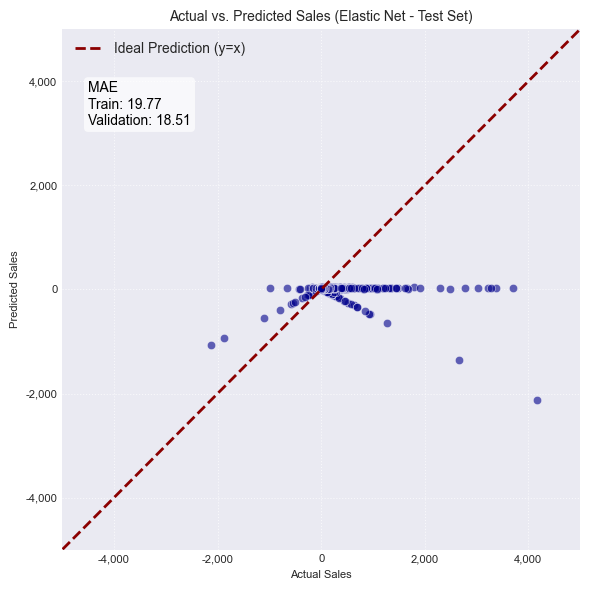

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6, color='darkblue')

min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], color='darkred', linestyle='--', linewidth=2, label='Ideal Prediction (y=x)')

plt.title(f'Actual vs. Predicted Sales (Elastic Net - Test Set)', fontsize=10)
plt.xlabel('Actual Sales', fontsize=8)
plt.ylabel('Predicted Sales', fontsize=8)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xlim(right=5000, left=-5000)
plt.ylim(top=5000, bottom=-5000)
plt.gca().tick_params(axis='y', labelsize=8)
plt.gca().tick_params(axis='x', labelsize=8)
plt.grid(True, linestyle=':', alpha=0.7)
plt.text(
    x=-4500, y=4000, 
    s=f'MAE\nTrain: {mae_en_train:,.2f}\nValidation: {mae_en_val:,.2f}', 
    fontsize=10, color='black',
    verticalalignment='top', horizontalalignment='left',
    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', lw=0, alpha=0.7)
)
plt.legend()
plt.tight_layout()
plt.show()

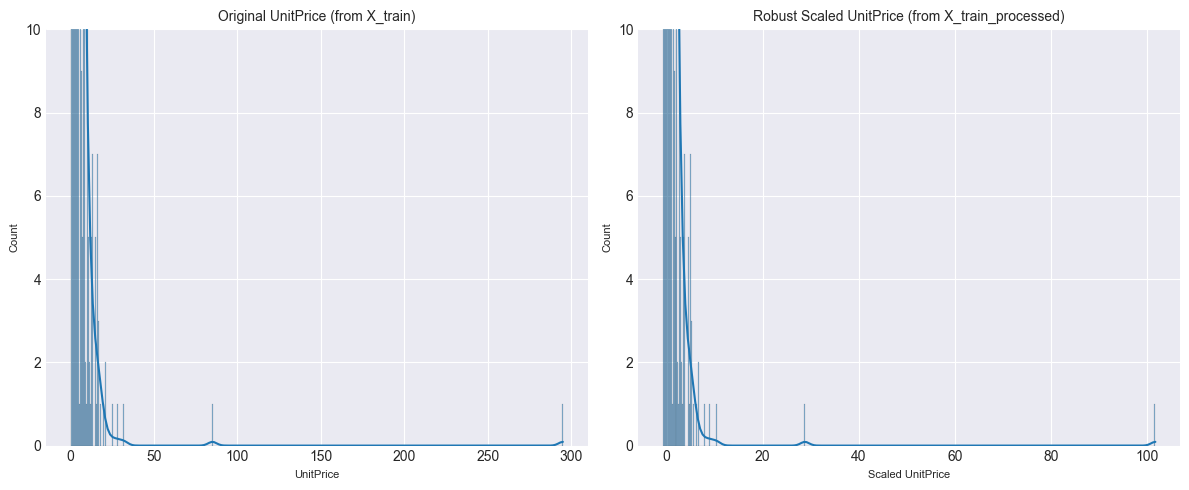


Mean of scaled 'unitprice': 0.8371188687100236
Median of scaled 'unitprice': 0.0
Std Dev of scaled 'unitprice': 28.04960933653877
IQR of scaled 'unitprice': 1.0


In [73]:
# (optional) plot diff. unit price
plt.figure(figsize=(12, 5))
common_ymax = 10

plt.subplot(1, 2, 1)
sns.histplot(X_train['unitprice'][0: 1000], kde=True)
plt.title('Original UnitPrice (from X_train)', fontsize=10)
plt.xlabel('UnitPrice', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.ylim(0, common_ymax)

unitprice_processed_col_index = 0
plt.subplot(1, 2, 2)
sns.histplot(X_train_processed_en[0: 1000, unitprice_processed_col_index], kde=True) # type: ignore
plt.title('Robust Scaled UnitPrice (from X_train_processed)', fontsize=10)
plt.xlabel('Scaled UnitPrice', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.ylim(0, common_ymax)

plt.tight_layout()
plt.show()

print("\nMean of scaled 'unitprice':", X_train_processed_en[:, unitprice_processed_col_index].mean()) # type: ignore
print("Median of scaled 'unitprice':", np.median(X_train_processed_en[:, unitprice_processed_col_index]))# type: ignore
print("Std Dev of scaled 'unitprice':", X_train_processed_en[:, unitprice_processed_col_index].std())# type: ignore
print("IQR of scaled 'unitprice':", np.percentile(X_train_processed_en[:, unitprice_processed_col_index], 75) - np.percentile(X_train_processed_en[:, unitprice_processed_col_index], 25)) # type: ignore


In [74]:
# 2. Random forest
print('--- Random Forest ---')

# data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import BinaryEncoder


# apply only categorical features, use binary encoder to limit dimension increase while handle missing values (customer id) with zero.
cat_transformer = Pipeline(steps=[('encoder', BinaryEncoder(cols=cat_cols, handle_missing='0'))])

# defines a preprocessor
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols)
    ]
)

# transform
X_train_processed_rf = preprocessor_rf.fit_transform(X_train)
X_val_processed_rf = preprocessor_rf.transform(X_val)
X_test_processed_rf = preprocessor_rf.transform(X_test)

print(f'Preprocessed Data\nX_train: {X_train_processed_rf.shape}, X_val: {X_val_processed_rf.shape}, X_test: {X_test_processed_rf.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}') # type: ignore


# initiate and train the model
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(
    n_estimators=1000,
    criterion="squared_error",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=1e-10,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    warm_start=False,
    ccp_alpha=0,
    max_samples=None,
).fit(X_train_processed_rf, y_train)

# prediction
y_pred_train = random_forest.predict(X_train_processed_rf)
y_pred_val = random_forest.predict(X_val_processed_rf)
y_pred_test = random_forest.predict(X_test_processed_rf)

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_rf_train = mean_squared_error(y_train, y_pred_train)
mse_rf_val = mean_squared_error(y_val, y_pred_val)
mse_rf_test = mean_squared_error(y_test, y_pred_test)
print(f'MSE\nTrain: {mse_rf_train:,.3f}, Validation: {mse_rf_val:,.3f}, Test: {mse_rf_test:,.3f}')

mae_rf_train = mean_absolute_error(y_train, y_pred_train)
mae_rf_val = mean_absolute_error(y_val, y_pred_val)
mae_rf_test = mean_absolute_error(y_test, y_pred_test)
print(f'MAE\nTrain: {mae_rf_train:,.3f}, Validation: {mae_rf_val:,.3f}, Test: {mae_rf_test:,.3f}')


--- Random Forest ---
Preprocessed Data
X_train: (441909, 76), X_val: (50000, 76), X_test: (50000, 76), y_train: (441909,), y_val: (50000,), y_test: (50000,)
MSE
Train: 23,404.961, Validation: 36,120.380, Test: 129,263.379
MAE
Train: 4.147, Validation: 10.551, Test: 11.206


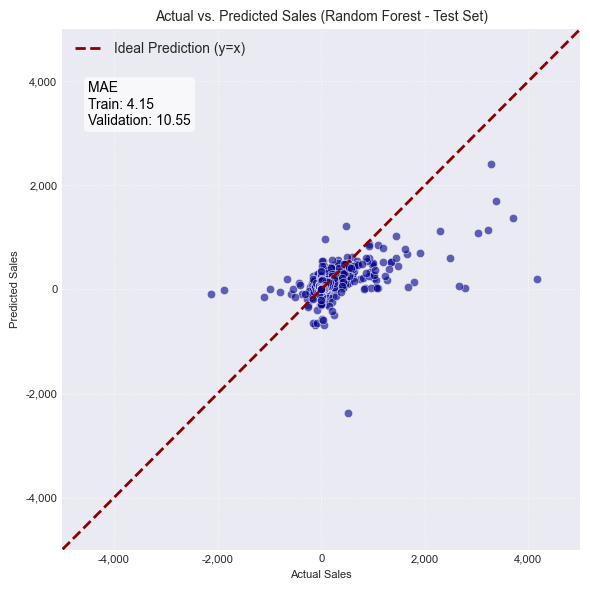

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6, color='darkblue')

min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], color='darkred', linestyle='--', linewidth=2, label='Ideal Prediction (y=x)')

plt.title(f'Actual vs. Predicted Sales (Random Forest - Test Set)', fontsize=10)
plt.xlabel('Actual Sales', fontsize=8)
plt.ylabel('Predicted Sales', fontsize=8)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xlim(right=5000, left=-5000)
plt.ylim(top=5000, bottom=-5000)
plt.gca().tick_params(axis='y', labelsize=8)
plt.gca().tick_params(axis='x', labelsize=8)
plt.grid(True, linestyle=':', alpha=0.7)
plt.text(
    x=-4500, y=4000, 
    s=f'MAE\nTrain: {mae_rf_train:,.2f}\nValidation: {mae_rf_val:,.2f}', 
    fontsize=10, color='black',
    verticalalignment='top', horizontalalignment='left',
    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', lw=0, alpha=0.7)
)
plt.legend()
plt.tight_layout()
plt.show()

In [77]:
# 3. dfn
print('--- DFN ---')

# data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import BinaryEncoder

# for num features, use standardscaler (robustscaler got nan mse)
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# for categorical features, use binary encoder to limit dimension increase while handle missing values (customer id) with zero.
cat_transformer = Pipeline(steps=[('encoder', BinaryEncoder(cols=cat_cols, handle_missing='0'))])

# defines a preprocessor
preprocessor_dfn = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ],
    remainder='passthrough'
)

# transform
X_train_processed = preprocessor_dfn.fit_transform(X_train)
X_val_processed = preprocessor_dfn.transform(X_val)
X_test_processed = preprocessor_dfn.transform(X_test)

print(f'Preprocessed Data:\nX_train: {X_train_processed.shape}, X_val: {X_val_processed.shape}, X_test: {X_test_processed.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}') # type: ignore


# initiate and train the model
from tensorflow import keras # type: ignore
from keras.models import Sequential # type: ignore
from keras.layers import Dense, Dropout, Input # type: ignore
from keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore
from keras.metrics import MeanSquaredError, MeanAbsoluteError

# Enable mixed_float16: This allows your model to perform operations using float16 (half-precision) where possible, which is faster and uses less memory on modern GPUs
from keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

keras_model = Sequential([
    Input(shape=(X_train_processed.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='linear', dtype='float32')
])
keras_model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[
        MeanSquaredError(name='mse'),
        MeanAbsoluteError(name='mae')
    ]
)
keras_model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',     # monitor loss
    mode='min',             # minimize loss
    patience=10,            # reduced patience for faster grid search
    min_delta=1e-10,         # minimum change to be considered an improvement (tol) # type: ignore
    verbose=0
)
check_point = ModelCheckpoint('best_dfn_keras_model.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

history = keras_model.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_processed, y_val),
    callbacks=[early_stopping, check_point],
    verbose=1 # type: ignore
)

# prediction + evaluation
loss_train, mse_train, mae_train = keras_model.evaluate(X_train_processed, y_train, verbose=0) #type: ignore
loss_val, mse_val, mae_val = keras_model.evaluate(X_val_processed, y_val, verbose=0) #type: ignore
loss_test, mse_test, mae_test = keras_model.evaluate(X_test_processed, y_test, verbose=0) #type: ignore

print(f"\nDFN (Keras) MSE - Train: {mse_train:.3f}, Val: {mse_val:.3f}, Test: {mse_test:.3f}")
print(f"\nDFN (Keras) MAE - Train: {mae_train:.3f}, Val: {mae_val:.3f}, Test: {mae_test:.3f}")


--- DFN ---
Preprocessed Data:
X_train: (441909, 81), X_val: (50000, 81), X_test: (50000, 81), y_train: (441909,), y_val: (50000,), y_test: (50000,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,873 (30.75 KB)

 Trainable params: 7,873 (30.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
13709/13810 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 78078.2344 - mae: 17.4431 - mse: 78078.2344
Epoch 1: val_loss improved from inf to 38428.80859, saving model to best_dfn_keras_model.keras
13810/13810 ━━━━━━━━━━━━━━━━━━━━ 7s 443us/step - loss: 78664.7578 - mae: 17.4419 - mse: 78664.7578 - val_loss: 38428.8086 - val_mae: 15.6054 - val_mse: 38428.8086
Epoch 2/100
13730/13810 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 104567.9688 - mae: 16.3967 - mse: 104567.9688
Epoch 2: val_loss did not improve from 38428.80859
13810/13810 ━━━━━━━━━━━━━━━━━━━━ 6s 444us/step - loss: 104870.9453 - mae: 16.3981 - mse: 104870.9453 - val_loss: 41718.6758 - val_mae: 15.9719 - val_mse: 41718.6758
Epoch 3/100
13756/13810 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 113733.0703 - mae: 15.9814 - mse: 113733.0703
Epoch 3: val_loss improved from 38428.80859 to 36820.17969, saving model to best_dfn_keras_model.keras
13810/13810 ━━━━━━━━━━━━━━━━━━━━ 6s 445us/step - loss: 113898.9688 - mae: 15.9825 - ms

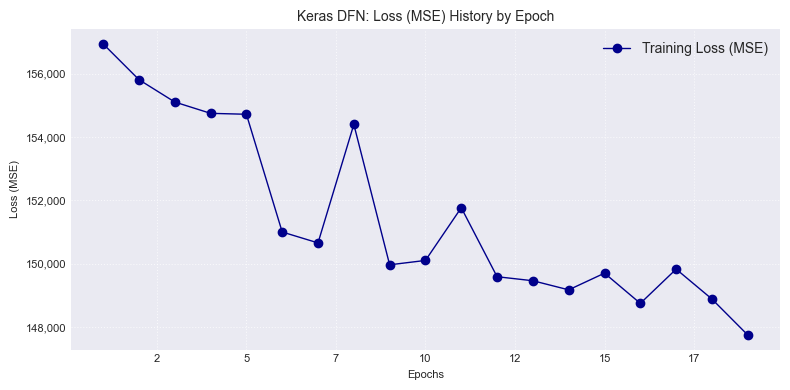

In [78]:
import matplotlib.pyplot as plt

losses = history.history['loss']
epochs = range(1, len(losses) + 1)
plt.figure(figsize=figsize)
plt.plot(epochs, losses, 'o-', label='Training Loss (MSE)', color='darkblue', lw=1)
# plt.plot(epochs, history['val_loss'], 'o-', label='Validation Loss (MSE)', color='darkred', lw=1)
plt.title('Keras DFN: Loss (MSE) History by Epoch', fontsize=10)
plt.xlabel('Epochs', fontsize=8)
plt.ylabel('Loss (MSE)', fontsize=8)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().tick_params(axis='y', labelsize=8)
plt.gca().tick_params(axis='x', labelsize=8)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print('--- 4. DFN on PyTorch ---')

# data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import BinaryEncoder

# for num features, use robust scaler to handle significant outliers
num_transformer = Pipeline(steps=[('scaler', 
                                #    RobustScaler(with_centering=True, with_scaling=True)
                                   StandardScaler()
                                   )])

# for categorical features, use binary encoder to limit dimension increase while handle missing values (customer id) with zero.
cat_transformer = Pipeline(steps=[('encoder', BinaryEncoder(cols=cat_cols, handle_missing='0'))])

# defines a preprocessor
preprocessor_dfn = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ],
    remainder='passthrough'
)

# transform
X_train_processed_dfn = preprocessor_dfn.fit_transform(X_train)
X_val_processed_dfn = preprocessor_dfn.transform(X_val)
X_test_processed_dfn = preprocessor_dfn.transform(X_test)

print(f'\nPreprocessed Data:\nX_train: {X_train_processed_dfn.shape}, X_val: {X_val_processed_dfn.shape}, X_test: {X_test_processed_dfn.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}') # type: ignore


# transform to Tensor
import torch
from torch.utils.data import DataLoader, TensorDataset

input_dim = X_train_processed_dfn.shape[1]

# converts a NumPy array (or Python list, etc.) into a PyTorch Tensor
X_train_tensor = torch.tensor(X_train_processed_dfn, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_processed_dfn, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed_dfn, dtype=torch.float32)

# transforms a 1D tensor like [0, 1, 0] into a 2D tensor [[0], [1], [0]], making its shape (N, 1)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# a utility class provided by PyTorch for a simple Dataset implementation that wraps multiple tensors.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# a core PyTorch utility func that handle batching, shuffling (if necessary), multi-processing data loading
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# initiate model
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


class DFN(nn.Module):
    def __init__(self, input_dim):
        super(DFN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x   


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = DFN(input_dim).to(device)
criterion = nn.L1Loss() # mae for pytorch
optimizer = optim.Adam(model.parameters(), lr=0.0001)
print(f'Pytorch Archtecture:\n{model}')

num_epochs = 100
best_val_loss = 0.1
patience = 10
patience_counter = 0
min_delta = 1e-4
history = {'train_loss': [], 'val_loss': [], 'train_mse': [], 'val_mse': [], 'train_mae': [], 'val_mae': [] }

# train
from sklearn.metrics import mean_squared_error, mean_absolute_error

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    all_train_preds = []
    all_train_targets = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * data.size(0)
        all_train_preds.extend(outputs.detach().cpu().numpy())
        all_train_targets.extend(target.detach().cpu().numpy())

    epoch_train_loss = running_train_loss / len(train_dataset)

    train_mse = mean_squared_error(np.array(all_train_targets), np.array(all_train_preds))
    train_mae = mean_absolute_error(np.array(all_train_targets), np.array(all_train_preds))

    model.eval()
    running_val_loss = 0.0
    all_val_preds = []
    all_val_targets = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            running_val_loss += loss.item() * data.size(0)
            all_val_preds.extend(outputs.cpu().numpy())
            all_val_targets.extend(target.cpu().numpy())

    epoch_val_loss = running_val_loss / len(val_dataset)

    val_preds_continuous = np.array(all_val_preds)
    val_targets_continuous = np.array(all_val_targets)
    val_mse = mean_squared_error(val_targets_continuous, val_preds_continuous)
    val_mae = mean_absolute_error(val_targets_continuous, val_preds_continuous)

    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['train_mse'].append(train_mse)
    history['val_mse'].append(val_mse)
    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)

    print(f'Epoch {epoch+1}/{num_epochs}: '
          f'Train Loss: {epoch_train_loss:.4f}, Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f} | '
          f'Val Loss: {epoch_val_loss:.4f}, Val MSE: {val_mse:.4f}, Val MAE: {val_mae:.4f}')

    torch.save(model.state_dict(), 'best_dfn_model.pth')
    if epoch_val_loss < best_val_loss - min_delta:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        print(f"Validation loss improved. Saving model to best_dfn_model.pth. Best Val Loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience: print(f"Early stopping triggered after {epoch+1} epochs."); break

model.load_state_dict(torch.load('best_dfn_model.pth'))


def evaluate_model(loader):
    model.eval()
    all_preds = []
    all_targets = []
    running_loss = 0.0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            running_loss += loss.item() * data.size(0)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    total_loss = running_loss / len(loader.dataset)
    preds_continuous = np.array(all_preds)
    targets_continuous = np.array(all_targets)

    mse = mean_squared_error(targets_continuous, preds_continuous)
    mae = mean_absolute_error(targets_continuous, preds_continuous)
    return total_loss, mse, mae

loss_train, mse_train, mae_train = evaluate_model(train_loader)
loss_val, mse_val, mae_val = evaluate_model(val_loader)
loss_test, mse_test, mae_test = evaluate_model(test_loader)
print(f"\nDFN (PyTorch) -MSE Train: {mse_train:.3f}, Val: {mse_val:.3f}, Test: {mse_test:.3f}")
print(f"\nDFN (PyTorch) -MAE Train: {mae_train:.3f}, Val: {mae_val:.3f}, Test: {mae_test:.3f}")

--- 4. DFN on PyTorch ---

Preprocessed Data:
X_train: (441909, 81), X_val: (50000, 81), X_test: (50000, 81), y_train: (441909,), y_val: (50000,), y_test: (50000,)
Using device: cpu
Pytorch Archtecture:
DFN(
  (fc1): Linear(in_features=81, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)
Epoch 1/100: Train Loss: 16.0815, Train MSE: 156829.0469, Train MAE: 16.0815 | Val Loss: 14.3063, Val MSE: 40689.8750, Val MAE: 14.3063
Epoch 2/100: Train Loss: 14.8659, Train MSE: 157107.5000, Train MAE: 14.8659 | Val Loss: 13.6438, Val MSE: 44355.9062, Val MAE: 13.6438
Epoch 3/100: Train Loss: 14.2748, Train MSE: 157622.9375, Train MAE: 14.2748 | Val Loss: 13.1375, Val MSE: 49636.1172, Val MAE: 13.1375
Epoch 4/100: Train Loss: 13.7495, Train MSE: 158364.2969, Train MAE: 13.7495 | 

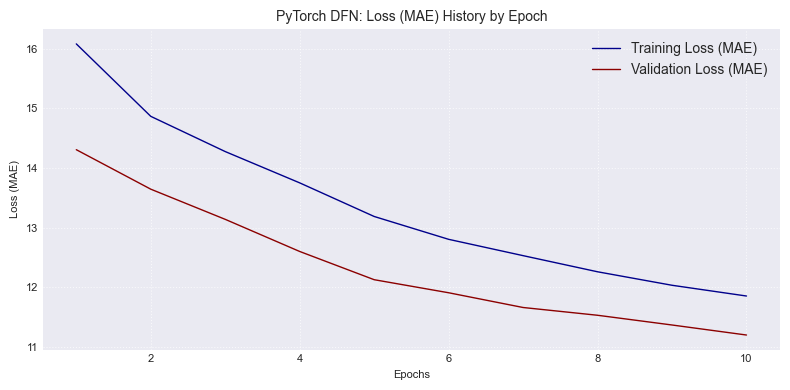

In [80]:
import matplotlib.pyplot as plt

epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=figsize)
plt.plot(epochs, history['train_loss'], '-', label='Training Loss (MAE)', color='darkblue', lw=1)
plt.plot(epochs, history['val_loss'], '-', label='Validation Loss (MAE)', color='darkred', lw=1)
plt.title('PyTorch DFN: Loss (MAE) History by Epoch', fontsize=10)
plt.xlabel('Epochs', fontsize=8)
plt.ylabel('Loss (MAE)', fontsize=8)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().tick_params(axis='y', labelsize=8)
plt.gca().tick_params(axis='x', labelsize=8)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Phase 2 - adding sales log

In [81]:
import numpy as np

df_fin_rev = df_fin.copy()
df_fin_rev['is_return'] = (df_fin_rev['sales'] < 0).astype(int)
df_fin_rev['sales'] = df_fin_rev['sales'].apply(lambda x: max(x, 0))
alpha = 1
df_fin_rev['sales'] = np.log(df_fin_rev['sales'] + alpha)

df_fin_rev.head().transpose()

,0,1,2,3,4
invoiceno,536365,536365,536365,536365,536365
stockcode,85123A,71053,84406B,84029G,84029E
quantity,6.0,6.0,8.0,6.0,6.0
invoicedate,1291191960.0,1291191960.0,1291191960.0,1291191960.0,1291191960.0
unitprice,2.55,3.39,2.75,3.39,3.39
customerid,17850.0,17850.0,17850.0,17850.0,17850.0
country,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom
is_registered,1,1,1,1,1
year,2010,2010,2010,2010,2010
year_month,12,12,12,12,12


In [82]:
df_fin_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   invoiceno                        541909 non-null  object  
 1   stockcode                        541909 non-null  object  
 2   quantity                         541909 non-null  float64 
 3   invoicedate                      541909 non-null  float64 
 4   unitprice                        541909 non-null  float64 
 5   customerid                       406829 non-null  float64 
 6   country                          541909 non-null  object  
 7   is_registered                    541909 non-null  int64   
 8   year                             541909 non-null  int32   
 9   year_month                       541909 non-null  int64   
 10  day_of_week                      541909 non-null  object  
 11  sales                            541909 non-null  fl

In [83]:
df_fin_rev.isna().sum()

invoiceno                               0
stockcode                               0
quantity                                0
invoicedate                             0
unitprice                               0
customerid                         135080
country                                 0
is_registered                           0
year                                    0
year_month                              0
day_of_week                             0
sales                                   0
unit_price_bin                          0
product_avg_quantity_last_month         0
customer_recency_days                   0
customer_total_spend_ltm                0
customer_freq_ltm                       0
is_return                               0
dtype: int64

In [84]:
cat_cols = [
    'invoiceno',
    'stockcode',
    'quantity',
    'customerid',
    'country',
    'year',
    'year_month',
    # 'month_name',
    'day_of_week',
    'is_registered',
    'unit_price_bin',
    'customer_recency_days',
    'is_return'
]
num_cols = ['unitprice', 'product_avg_quantity_last_month', 'customer_total_spend_ltm', 'customer_freq_ltm', 'invoicedate']
target_col = 'sales'


In [85]:
from sklearn.model_selection import train_test_split

X = df_fin_rev.copy().drop(columns=target_col)
y = df_fin_rev.copy()[target_col]

test_size = 50000
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=test_size, random_state=42)

print(f'Original Datasets\nX_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}')

Original Datasets
X_train: (441909, 17), X_val: (50000, 17), X_test: (50000, 17), y_train: (441909,), y_val: (50000,), y_test: (50000,)


In [86]:
print('--- Elastic Net ---')

# data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import BinaryEncoder

# for num features, use robust scaler to handle significant outliers
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# for categorical features, use binary encoder to limit dimension increase while handle missing values (customer id) with zero.
cat_transformer = Pipeline(steps=[
    ('encoder', BinaryEncoder(cols=cat_cols, handle_missing='0'))
])

# defines a preprocessor
preprocessor_en = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ],
    remainder='passthrough' 
)

# transform
X_train_processed_en = preprocessor_en.fit_transform(X_train)
X_val_processed_en = preprocessor_en.transform(X_val)
X_test_processed_en = preprocessor_en.transform(X_test)

print(f'Preprocessed Data:\nX_train: {X_train_processed_en.shape}, X_val: {X_val_processed_en.shape}, X_test: {X_test_processed_en.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}') # type: ignore


# initiate and train the model
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(
    alpha=1,            # total strength of the regularization
    l1_ratio=0.5,       # l1 to l2 ration = 1:1
    fit_intercept=True, # fits a y-intercept by computing it
    precompute=False,   # no use precomputed Gram matrix
    max_iter=5000,      # 1,000 epochs
    copy_X=True,        # copies X before fitting
    tol=1e-5,           # tol to stop iteration
    random_state=42,    # seed for the random number generato
    warm_start=False,   # ignores solutions from the previous fit call
    positive=False,     # can both negative and positive coefficient
    selection="cyclic"  # updates coefficients cyclically one by one (vs random)
).fit(X_train_processed_en, y_train) # This line looks correct: model fits on processed X and original y


# prediction
y_pred_train = elastic_net.predict(X_train_processed_en) # Predicts on processed training features
y_pred_val = elastic_net.predict(X_val_processed_en)
y_pred_test = elastic_net.predict(X_test_processed_en)

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_en_train = mean_squared_error(y_train, y_pred_train)
mse_en_val = mean_squared_error(y_val, y_pred_val)
mse_en_test = mean_squared_error(y_test, y_pred_test)
print(f'MSE\nTrain: {mse_en_train:,.3f}, Validation: {mse_en_val:,.3f}, Test: {mse_en_test:,.3f}')

mae_en_train_exp = mean_absolute_error(np.exp(y_train), np.exp(y_pred_train))
mae_en_val_exp = mean_absolute_error(np.exp(y_val), np.exp(y_pred_val))
mae_en_test_exp = mean_absolute_error(np.exp(y_test), np.exp(y_pred_test))
print(f'\nMAE (EXP: Real Sales Values)\nTrain: {mae_en_train_exp:,.3f}, Validation: {mae_en_val_exp:,.3f}, Test: {mae_en_test_exp:,.3f}')


--- Elastic Net ---
Preprocessed Data:
X_train: (441909, 83), X_val: (50000, 83), X_test: (50000, 83), y_train: (441909,), y_val: (50000,), y_test: (50000,)
MSE
Train: 1.133, Validation: 1.132, Test: 1.122

MAE (EXP: Real Sales Values)
Train: 15.825, Validation: 14.714, Test: 16.509


In [87]:
# 2. Random forest
print('--- Random Forest ---')

# data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import BinaryEncoder


# apply only categorical features, use binary encoder to limit dimension increase while handle missing values (customer id) with zero.
cat_transformer = Pipeline(steps=[('encoder', BinaryEncoder(cols=cat_cols, handle_missing='0'))])

# defines a preprocessor
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols)
    ]
)

# transform
X_train_processed_rf = preprocessor_rf.fit_transform(X_train)
X_val_processed_rf = preprocessor_rf.transform(X_val)
X_test_processed_rf = preprocessor_rf.transform(X_test)

print(f'Preprocessed Data\nX_train: {X_train_processed_rf.shape}, X_val: {X_val_processed_rf.shape}, X_test: {X_test_processed_rf.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}') # type: ignore


# initiate and train the model
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(
    n_estimators=1000,
    criterion="squared_error",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=1e-10,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    warm_start=False,
    ccp_alpha=0,
    max_samples=None,
).fit(X_train_processed_rf, y_train)

# prediction
y_pred_train = random_forest.predict(X_train_processed_rf)
y_pred_val = random_forest.predict(X_val_processed_rf)
y_pred_test = random_forest.predict(X_test_processed_rf)

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_rf_train = mean_squared_error(y_train, y_pred_train)
mse_rf_val = mean_squared_error(y_val, y_pred_val)
mse_rf_test = mean_squared_error(y_test, y_pred_test)

print(f'MSE\nTrain: {mse_rf_train:,.3f}, Validation: {mse_rf_val:,.3f}, Test: {mse_rf_test:,.3f}')

mae_rf_train_exp = mean_absolute_error(np.exp(y_train), np.exp(y_pred_train))
mae_rf_val_exp = mean_absolute_error(np.exp(y_val), np.exp(y_pred_val))
mae_rf_test_exp = mean_absolute_error(np.exp(y_test), np.exp(y_pred_test))
print(f'\nMAE (EXP: Real Sales Values)\nTrain: {mae_rf_train_exp:,.3f}, Validation: {mae_rf_val_exp:,.3f}, Test: {mae_rf_test_exp:,.3f}')



--- Random Forest ---
Preprocessed Data
X_train: (441909, 78), X_val: (50000, 78), X_test: (50000, 78), y_train: (441909,), y_val: (50000,), y_test: (50000,)
MSE
Train: 0.020, Validation: 0.175, Test: 0.176

MAE (EXP: Real Sales Values)
Train: 4.135, Validation: 7.187, Test: 9.041


In [88]:
# 3. dfn
print('--- DFN ---')

# data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import BinaryEncoder

# for num features, use standardscaler (robustscaler got nan mse)
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# for categorical features, use binary encoder to limit dimension increase while handle missing values (customer id) with zero.
cat_transformer = Pipeline(steps=[('encoder', BinaryEncoder(cols=cat_cols, handle_missing='0'))])

# defines a preprocessor
preprocessor_dfn = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ],
    remainder='passthrough'
)

# transform
X_train_processed = preprocessor_dfn.fit_transform(X_train)
X_val_processed = preprocessor_dfn.transform(X_val)
X_test_processed = preprocessor_dfn.transform(X_test)

print(f'Preprocessed Data:\nX_train: {X_train_processed.shape}, X_val: {X_val_processed.shape}, X_test: {X_test_processed.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}') # type: ignore


# initiate and train the model
from tensorflow import keras # type: ignore
from keras.models import Sequential # type: ignore
from keras.layers import Dense, Dropout, Input # type: ignore
from keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore
from keras.metrics import MeanSquaredError, MeanAbsoluteError

# Enable mixed_float16: This allows your model to perform operations using float16 (half-precision) where possible, which is faster and uses less memory on modern GPUs
from keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

keras_model = Sequential([
    Input(shape=(X_train_processed.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='linear', dtype='float32')
])
keras_model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[
        MeanSquaredError(name='mse'),
        MeanAbsoluteError(name='mae')
    ]
)
keras_model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',     # monitor loss
    mode='min',             # minimize loss
    patience=10,            # reduced patience for faster grid search
    min_delta=1e-10,         # minimum change to be considered an improvement (tol) # type: ignore
    verbose=0
)
check_point = ModelCheckpoint('best_dfn_keras_model.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

history = keras_model.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_processed, y_val),
    callbacks=[early_stopping, check_point],
    verbose=1 # type: ignore
)

# prediction + evaluation
loss_train, mse_train, mae_train = keras_model.evaluate(X_train_processed, y_train, verbose=0) #type: ignore
loss_val, mse_val, mae_val = keras_model.evaluate(X_val_processed, y_val, verbose=0) #type: ignore
loss_test, mse_test, mae_test = keras_model.evaluate(X_test_processed, y_test, verbose=0) #type: ignore
print(f"\nDFN - Train: {mse_train:.3f}, Val: {mse_val:.3f}, Test: {mse_test:.3f}")


--- DFN ---
Preprocessed Data:
X_train: (441909, 83), X_val: (50000, 83), X_test: (50000, 83), y_train: (441909,), y_val: (50000,), y_test: (50000,)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
13697/13810 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 1.4858 - mae: 0.5142 - mse: 1.4858
Epoch 1: val_loss improved from inf to 0.14760, saving model to best_dfn_keras_model.keras
13810/13810 ━━━━━━━━━━━━━━━━━━━━ 8s 515us/step - loss: 1.5155 - mae: 0.5131 - mse: 1.5155 - val_loss: 0.1476 - val_mae: 0.2462 - val_mse: 0.1476
Epoch 2/100
13764/13810 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 24.5740 - mae: 0.2385 - mse: 24.5740
Epoch 2: val_loss improved from 0.14760 to 0.10549, saving model to best_dfn_keras_model.keras
13810/13810 ━━━━━━━━━━━━━━━━━━━━ 6s 445us/step - loss: 24.7474 - mae: 0.2385 - mse: 24.7474 - val_loss: 0.1055 - val_mae: 0.1978 - val_mse: 0.1055
Epoch 3/100
13755/13810 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 133.7691 - mae: 0.2193 - mse: 133.7691
Epoch 3: val_loss did not improve from 0.10549
13810/13810 ━━━━━━━━━━━━━━━━━━━━ 6s 444us/step - loss: 133.7428 - mae: 0.2193 - mse: 133.7428 - val_loss: 0.1223 - val_mae: 0.2105 - val_mse: 0.1223
Epoch 4/100
13

In [89]:
print('--- 4. DFN on PyTorch ---')

# data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import BinaryEncoder

num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('encoder', BinaryEncoder(cols=cat_cols, handle_missing='0'))])

preprocessor_dfn = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ],
    remainder='passthrough'
)

# transform
X_train_processed_dfn = preprocessor_dfn.fit_transform(X_train)
X_val_processed_dfn = preprocessor_dfn.transform(X_val)
X_test_processed_dfn = preprocessor_dfn.transform(X_test)

print(f'\nPreprocessed Data:\nX_train: {X_train_processed_dfn.shape}, X_val: {X_val_processed_dfn.shape}, X_test: {X_test_processed_dfn.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}') # type: ignore


# transform to Tensor
import torch
from torch.utils.data import DataLoader, TensorDataset

input_dim = X_train_processed_dfn.shape[1]

# converts a NumPy array (or Python list, etc.) into a PyTorch Tensor
X_train_tensor = torch.tensor(X_train_processed_dfn, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_processed_dfn, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed_dfn, dtype=torch.float32)

# transforms a 1D tensor like [0, 1, 0] into a 2D tensor [[0], [1], [0]], making its shape (N, 1)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# a utility class provided by PyTorch for a simple Dataset implementation that wraps multiple tensors.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# a core PyTorch utility func that handle batching, shuffling (if necessary), multi-processing data loading
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# initiate model
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


class DFN(nn.Module):
    def __init__(self, input_dim):
        super(DFN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x   


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = DFN(input_dim).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
print(f'Pytorch Archtecture:\n{model}')

num_epochs = 100
best_val_loss = float('inf')
patience = 10
patience_counter = 0
min_delta = 1e-4
history = {
    'train_loss': [], 'val_loss': [], 
    'train_mse': [], 'val_mse': [], 
    'train_mae': [], 'val_mae': [],
    'exp_train_mse': [], 'exp_val_mse': [],
    'exp_train_mae': [], 'exp_val_mae': []
}

# train
from sklearn.metrics import mean_squared_error, mean_absolute_error

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    all_train_preds = []
    all_train_targets = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * data.size(0)
        all_train_preds.extend(outputs.detach().cpu().numpy())
        all_train_targets.extend(target.detach().cpu().numpy())

    epoch_train_loss = running_train_loss / len(train_dataset)

    pred_train = np.array(all_train_preds)
    target_train = np.array(all_train_targets)
    train_mse = mean_squared_error(target_train, pred_train)
    train_mae = mean_absolute_error(target_train, pred_train)

    exp_train_preds = np.exp(pred_train)
    exp_train_targets = np.exp(target_train)
    try:
        exp_train_mse = mean_squared_error(exp_train_targets, exp_train_preds)
        exp_train_mae = mean_absolute_error(exp_train_targets, exp_train_preds)
    except:
        exp_train_mse = 0
        exp_train_mae = 0


    model.eval()
    running_val_loss = 0.0
    all_val_preds = []
    all_val_targets = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            running_val_loss += loss.item() * data.size(0)
            all_val_preds.extend(outputs.cpu().numpy())
            all_val_targets.extend(target.cpu().numpy())

    epoch_val_loss = running_val_loss / len(val_dataset)

    pred_val = np.array(all_val_preds)
    target_val = np.array(all_val_targets)
    val_mse = mean_squared_error(target_val, pred_val)
    val_mae = mean_absolute_error(target_val, pred_val)

    exp_val_preds = np.exp(pred_val)
    exp_val_targets = np.exp(target_val)
    try:
        exp_val_mse = mean_squared_error(exp_val_targets, exp_val_preds)
        exp_val_mae = mean_absolute_error(exp_val_targets, exp_val_preds)
    except:
        exp_val_mse = 0
        exp_val_mae = 0

    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['train_mse'].append(train_mse)
    history['val_mse'].append(val_mse)
    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    history['exp_train_mse'].append(exp_train_mse)
    history['exp_val_mse'].append(exp_val_mse)
    history['exp_train_mae'].append(exp_train_mae)
    history['exp_val_mae'].append(exp_val_mae)

    print(f'Epoch {epoch+1}/{num_epochs}: '
          f'Train Loss: {epoch_train_loss:.4f}, Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f} | '
          f'Val Loss: {epoch_val_loss:.4f}, Val MSE: {val_mse:.4f}, Val MAE: {val_mae:.4f}')

    torch.save(model.state_dict(), 'best_dfn_model.pth')
    if epoch_val_loss < best_val_loss - min_delta:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        print(f"Validation loss improved. Saving model to best_dfn_model.pth. Best Val Loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience: print(f"Early stopping triggered after {epoch+1} epochs."); break

model.load_state_dict(torch.load('best_dfn_model.pth'))


def evaluate_model(loader):
    model.eval()
    all_preds = []
    all_targets = []
    running_loss = 0.0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            running_loss += loss.item() * data.size(0)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    total_loss = running_loss / len(loader.dataset)
    preds_continuous = np.array(all_preds)
    targets_continuous = np.array(all_targets)
    clipped_targets = np.clip(targets_continuous, -np.inf, 10)
    clipped_preds = np.clip(preds_continuous, -np.inf, 10)

    mse = mean_squared_error(targets_continuous, preds_continuous)
    mae = mean_absolute_error(targets_continuous, preds_continuous)
    exp_mse = mean_squared_error(np.exp(clipped_targets), np.exp(clipped_preds))
    exp_mae = mean_absolute_error(np.exp(clipped_targets), np.exp(clipped_preds))

    return total_loss, mse, mae, exp_mse, exp_mae

loss_train, mse_train, mae_train, exp_mse_train, exp_mae_train = evaluate_model(train_loader)
loss_val, mse_val, mae_val, exp_mse_val, exp_mae_val = evaluate_model(val_loader)
loss_test, mse_test, mae_test, exp_mse_test, exp_mae_test = evaluate_model(test_loader)

print(f"\nDFN (PyTorch) - Train MSE: {mse_train:.3f}, Val MSE: {mse_val:.3f}, Test MSE: {mse_test:.3f}")
# print(f"\nDFN (PyTorch) EXP Train MSE: {exp_mse_train:.3f}, Val MSE: {exp_mse_val:.3f}, Test MSE: {exp_mse_test:.3f}")

# print(f"\nDFN (PyTorch) - Train MAE: {mae_train:.3f}, Val mae: {mae_val:.3f}, Test mae: {mae_test:.3f}")
print(f"\nDFN (PyTorch) EXP Train MAE: {exp_mae_train:.3f}, Val mae: {exp_mae_val:.3f}, Test mae: {exp_mae_test:.3f}")


--- 4. DFN on PyTorch ---

Preprocessed Data:
X_train: (441909, 83), X_val: (50000, 83), X_test: (50000, 83), y_train: (441909,), y_val: (50000,), y_test: (50000,)
Using device: cpu
Pytorch Archtecture:
DFN(
  (fc1): Linear(in_features=83, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)
Epoch 1/100: Train Loss: 0.7128, Train MSE: 0.9911, Train MAE: 0.7128 | Val Loss: 0.4912, Val MSE: 0.9424, Val MAE: 0.4912
Validation loss improved. Saving model to best_dfn_model.pth. Best Val Loss: 0.4912
Epoch 2/100: Train Loss: 0.5089, Train MSE: 0.6062, Train MAE: 0.5089 | Val Loss: 0.3572, Val MSE: 0.7477, Val MAE: 0.3572
Validation loss improved. Saving model to best_dfn_model.pth. Best Val Loss: 0.3572
Epoch 3/100: Train Loss: 0.4047, Train MSE: 0.4506, Train MAE: 0.4047 | V


Test Set Metrics (on original scale):
Exp MSE: 27523469541376.000
Exp MAE: 23477.275


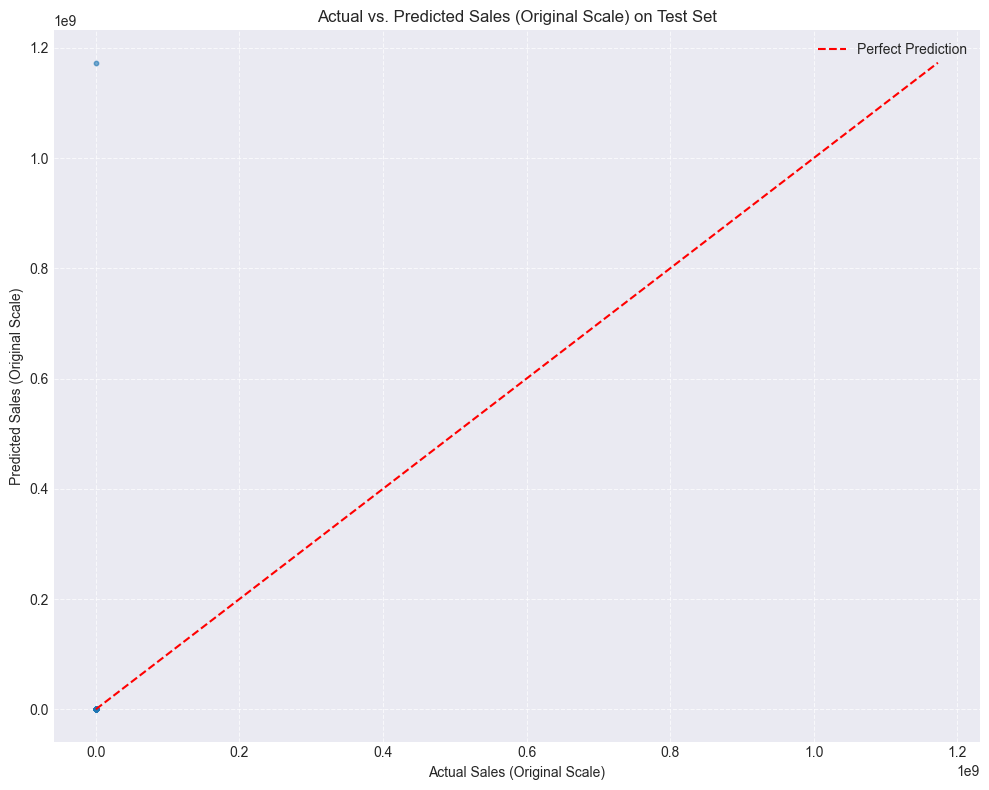

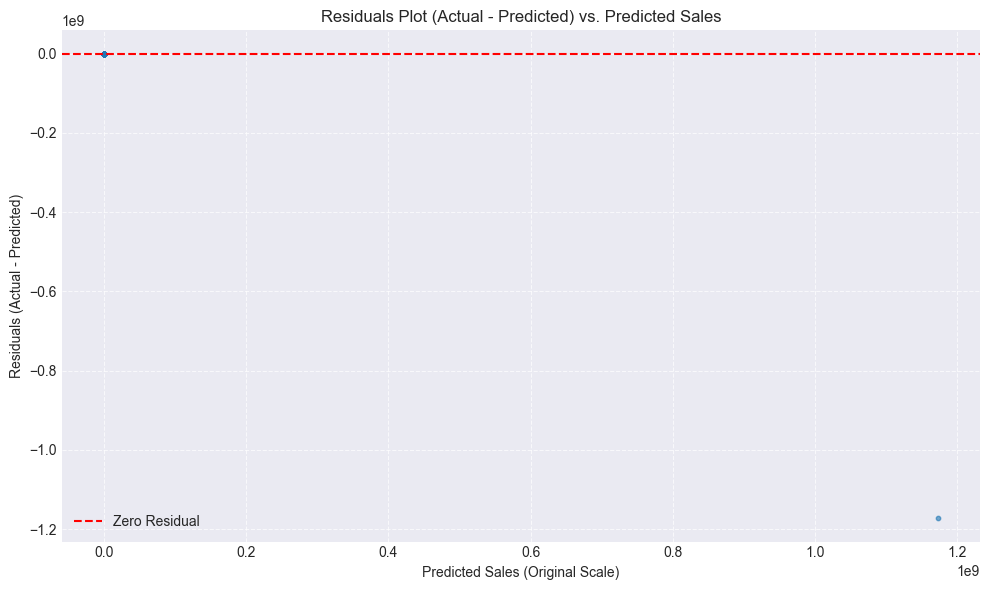

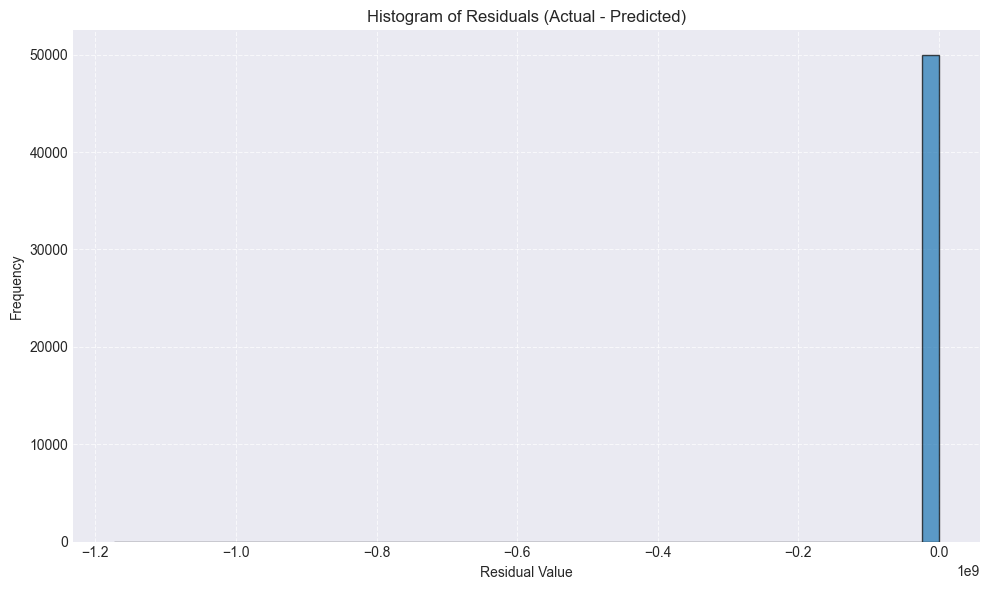

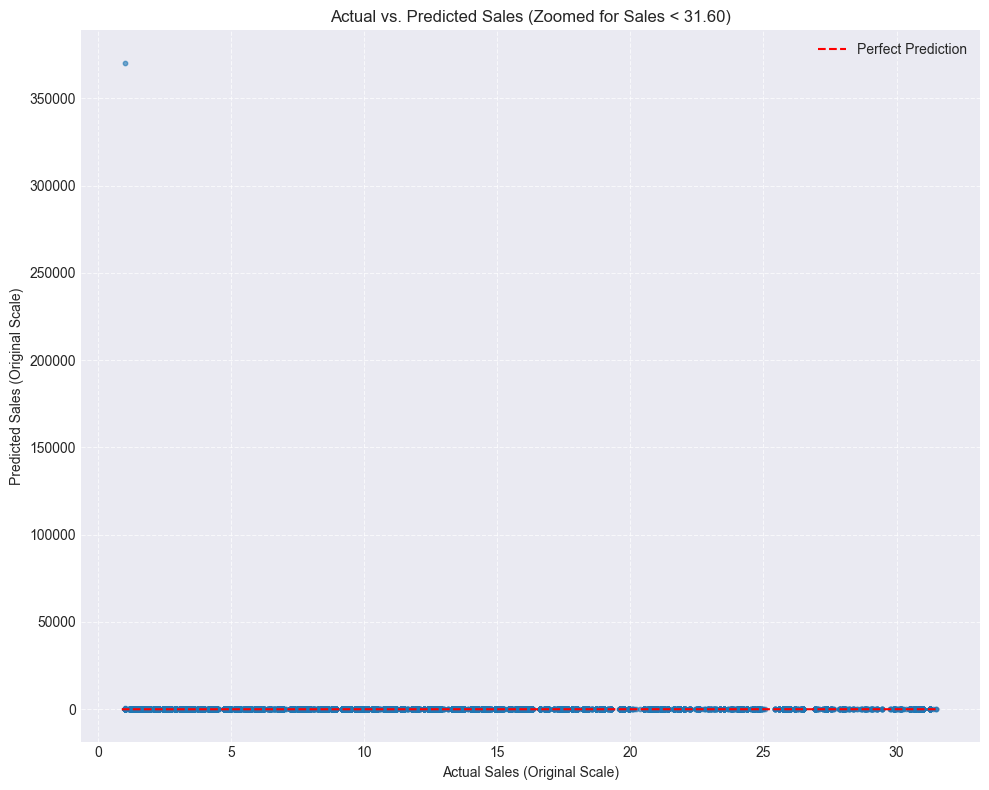

In [90]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error 

all_test_preds = []
all_test_targets = []

model.eval() 
with torch.no_grad(): 
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        all_test_preds.extend(outputs.cpu().numpy())
        all_test_targets.extend(target.cpu().numpy())

log_test_preds = np.array(all_test_preds).flatten() 
log_test_targets = np.array(all_test_targets).flatten()

exp_test_preds = np.exp(log_test_preds)
exp_test_targets = np.exp(log_test_targets)

exp_mse_test = mean_squared_error(exp_test_targets, exp_test_preds)
exp_mae_test = mean_absolute_error(exp_test_targets, exp_test_preds)
print(f"\nTest Set Metrics (on original scale):")
print(f"Exp MSE: {exp_mse_test:.3f}")
print(f"Exp MAE: {exp_mae_test:.3f}")

plt.figure(figsize=(10, 8))

plt.scatter(exp_test_targets, exp_test_preds, alpha=0.6, s=10) 

max_val = max(exp_test_targets.max(), exp_test_preds.max())
min_val = min(exp_test_targets.min(), exp_test_preds.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')

plt.title('Actual vs. Predicted Sales (Original Scale) on Test Set')
plt.xlabel('Actual Sales (Original Scale)')
plt.ylabel('Predicted Sales (Original Scale)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout() 
plt.show()

residuals = exp_test_targets - exp_test_preds

plt.figure(figsize=(10, 6))
plt.scatter(exp_test_preds, residuals, alpha=0.6, s=10)
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual')
plt.title('Residuals Plot (Actual - Predicted) vs. Predicted Sales')
plt.xlabel('Predicted Sales (Original Scale)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.title('Histogram of Residuals (Actual - Predicted)')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

threshold = np.percentile(exp_test_targets, 90) 

plt.figure(figsize=(10, 8))
plt.scatter(exp_test_targets[exp_test_targets < threshold], exp_test_preds[exp_test_targets < threshold], alpha=0.6, s=10)
plt.plot([min_val, threshold], [min_val, threshold], color='red', linestyle='--', label='Perfect Prediction')
plt.title(f'Actual vs. Predicted Sales (Zoomed for Sales < {threshold:.2f})')
plt.xlabel('Actual Sales (Original Scale)')
plt.ylabel('Predicted Sales (Original Scale)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()